In [ ]:
!pip install geopandas
!pip install contextily
!pip install cartopy
!pip install networkx[default]
!pip install pygplates

In [2]:
import gzip
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from cartopy import *
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from shapely import *
import json
import pandas as pd
import numpy as np
import networkx as nx
from collections import *
import pygplates

In [ ]:
# A function to traverse the sub-tree rooted at a particular plate (the moving plate of 'edge').
def traverse_sub_tree(edge, depth):

    relative_total_rotation = edge.get_relative_total_rotation()
    relative_pole_latitude, relative_pole_longitude, relative_angle_degrees = (
        relative_total_rotation.get_lat_lon_euler_pole_and_angle_degrees())

    equivalent_total_rotation = edge.get_equivalent_total_rotation()
    equivalent_pole_latitude, equivalent_pole_longitude, equivalent_angle_degrees = (
        equivalent_total_rotation.get_lat_lon_euler_pole_and_angle_degrees())

    prefix_padding = ' ' * (2*depth)

    print('%sPlate ID: %d, Fixed Plate ID: %d:' % (prefix_padding, edge.get_moving_plate_id(), edge.get_fixed_plate_id()))

    print('%s  Rotation rel. fixed (parent) plate: lat: %f, lon: %f:, angle:%f' % (
        prefix_padding, relative_pole_latitude, relative_pole_longitude, relative_angle_degrees))

    print('%s  Equivalent rotation rel. anchored plate: lat: %f, lon: %f:, angle:%f' % (
        prefix_padding, equivalent_pole_latitude, equivalent_pole_longitude, equivalent_angle_degrees))

    # Blank line.
    print

    # Recurse into the children sub-trees.
    for child_edge in edge.get_child_edges():
        traverse_sub_tree(child_edge, depth + 1)


# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel('rotation.rot')

# The reconstruction time (Ma) of the plate hierarchy we're interested in.
reconstruction_time = 60

# Get the reconstruction tree.
reconstruction_tree = rotation_model.get_reconstruction_tree(reconstruction_time)

# Get the edges of the reconstruction tree emanating from its root (anchor) plate.
anchor_plate_edges = reconstruction_tree.get_anchor_plate_edges()

# Iterate over the anchor plate edges and traverse the sub-tree of each edge.
i=0
for anchor_plate_edge in anchor_plate_edges:
    i+=1
    if i>9:
        traverse_sub_tree(anchor_plate_edge, 0)
    if i>11:
        break

In [ ]:
# Names of input files
input_feature_filename = 'Data/Seton_etal_ESR2012_Coastlines_2012.1_Polygon.gpmlz'
input_rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'

# Input parameters to define how the reconstruction is made
reconstruction_time = 120.6
anchor_plate = 0

# Name of ouput file
output_reconstructed_feature_filename = '/tmp/tmp.shp'

# Use pygplates to carry out the reconstruction
pygplates.reconstruct(input_feature_filename, input_rotation_filename, output_reconstructed_feature_filename,
                      reconstruction_time, anchor_plate)

In [ ]:
def read_file(filepath):
  try:
    with open(filepath, 'r') as f:
      content = f.read()
    return content
  except FileNotFoundError:
    print(f"Error: File '{filepath}' not found.")
    return None

# Example usage: Assuming 'rotation.rot' is in the current directory
rot = read_file('rotation.rot')
rot

In [ ]:
rot = rot.strip().split('\n')
rot[:7]

In [ ]:
rot[1000:1010]

In [ ]:
import gzip
import shutil

def unzip_gzip_file(input_file, output_file):
    """Unzips a gzip file.

    Args:
        input_file: Path to the gzip file.
        output_file: Path to the output file (unzipped).
    """
    try:
        with gzip.open(input_file, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Successfully unzipped '{input_file}' to '{output_file}'")
    except FileNotFoundError:
        print(f"Error: File '{input_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage
unzip_gzip_file('coastlines.gpmlz', 'coastlines.gpml')

Successfully unzipped 'coastlines.gpmlz' to 'coastlines.gpml'


In [ ]:
unzip_gzip_file('/content/data/coastlines.gpmlz', '/content/data/coastlines.gpml')

Successfully unzipped '/content/data/coastlines.gpmlz' to '/content/data/coastlines.gpml'


In [ ]:
unzip_gzip_file('/content/data/continents.gpmlz', '/content/data/continents.gpml')

Successfully unzipped '/content/data/continents.gpmlz' to '/content/data/continents.gpml'


In [ ]:
unzip_gzip_file('/content/data/dynamicPolygons.gpmlz', '/content/data/dynamicPolygons.gpml')

Error: File '/content/data/dynamicPolygons.gpmlz' not found.


In [ ]:
gpml = read_file('coastlines.gpml')

In [ ]:
coords_df['name'].unique()

array(['Pacific', 'Marie Byrd Land', 'Africa', 'Northwest Africa',
       'Caribbean Ocean Floor', 'Zamboanga Peninsula', 'Andaman Sea west',
       'North America', 'South America', 'South Bismark Basin',
       'Halmahera Basin', 'Corsica/Sardinia', 'Sandwich Plate',
       'Falkland Plateau, trapped Scotia Sea', 'Iberia', 'Eurasia',
       'Nazca', 'Palawan Block', 'Solomon Sea', 'Farallon', 'Cocos',
       'Greenland', 'De Long/Henrietta Block', 'Sea of Okhotsk',
       'Macquarie Ridge', 'Outer Bering Shelf',
       'Northwest South Fiji Basin', 'Seychelles', 'Madagascar', 'Arabia',
       'Somalia', 'Australia', 'Antarctica',
       'Santa Cruz Basin, Lord Howe Rise', 'Owen Basin',
       'Northwest Africa-Bahamas'], dtype=object)

In [ ]:
polygons = []
for feature in features:
    for coord_set in feature['coordinates']:
        # Convert to format expected by Shapely
        polygon = Polygon(coord_set)
        polygons.append({
            'name': feature['name'],
            'geometry': polygon
        })

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(polygons)

In [149]:
tree = ET.parse('coastlines.gpml')
root = tree.getroot()

In [150]:
namespaces = {
    'gml': 'http://www.opengis.net/gml',
    'gpml': 'http://www.gplates.org/gplates'
}

In [151]:
root

<Element '{http://www.gplates.org/gplates}FeatureCollection' at 0x7ec149fc07c0>

In [152]:
features = root.findall('.//gml:featureMember', namespaces)

In [ ]:
featureTypes = set()
for feature in features:
    # Get all immediate children of this feature
    children = list(feature)
    assert len(children) == 1

    tag_name = children[0].tag.split('}')[-1]  # This removes the namespace part
    featureTypes.add(tag_name)

print(featureTypes)

{'IslandArc', 'Basin', 'ClosedContinentalBoundary'}


In [ ]:
continents = root.findall('.//gpml:ClosedContinentalBoundary', namespaces)
len(continents)

1781

In [ ]:
positions = root.findall('.//gml:posList', namespaces)
len(positions)

2503

In [21]:
def create_plate_map(polygons, title='Tectonic Plates Reconstruction'):
    # Create figure with Robinson projection
    fig = plt.figure(figsize=(15, 10))
    proj = ccrs.Robinson()
    ax = plt.axes(projection=proj)

    # Add global features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # Plot each plate polygon - with correct transform
    for poly in polygons:
        ax.add_geometries([poly],
                         crs=ccrs.PlateCarree(),  # Source CRS
                         facecolor='none',
                         edgecolor='red',
                         linewidth=2)

    # Set title
    plt.title(title)

    return fig, ax

    # fig = plt.figure(figsize=(14,10))
    # ax_map = fig.add_subplot(111, projection=ccrs.Robinson())

    # for poly in polygons:
    #     ft_coast = cfeature.ShapelyFeature(poly, crs=ccrs.PlateCarree())
    #     ax_map.add_feature(ft_coast, facecolor='Wheat', edgecolor='Grey')

    # plt.title(title)

    # return fig, ax_map

In [ ]:
polygons = []
for position in positions:
    position_list = position.text.split()
    coord_pairs = [(float(position_list[i]), float(position_list[i+1]))
                             for i in range(0, len(position_list), 2)]
    polygons.append(Polygon(coord_pairs))

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

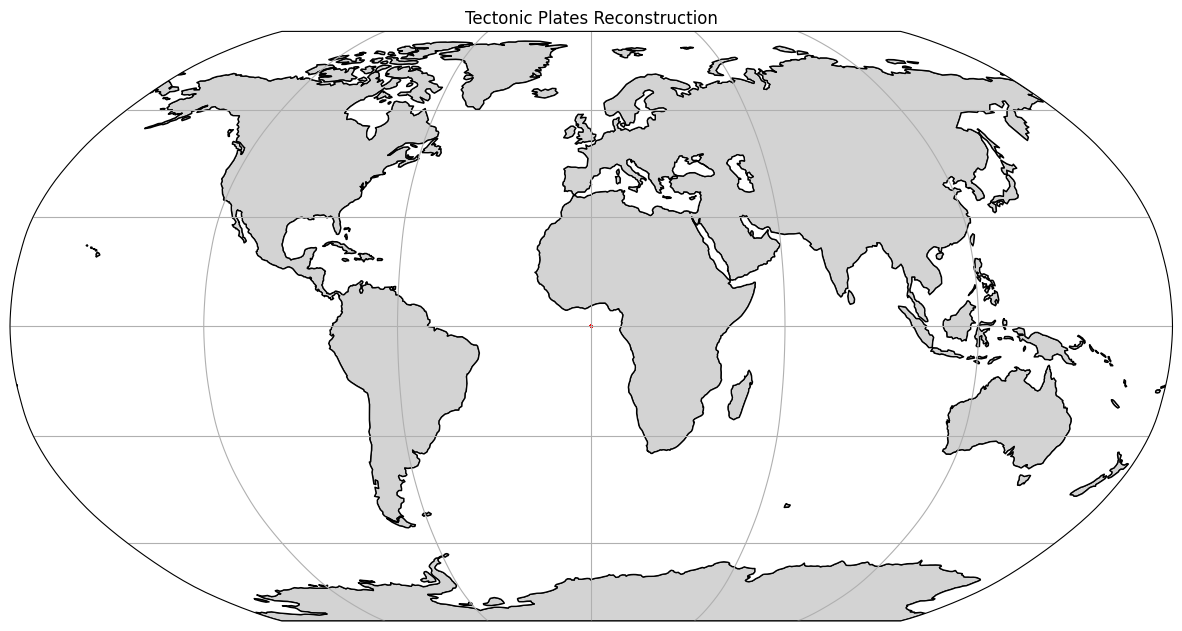

In [ ]:
create_plate_map(polygons)

In [ ]:
features[0].findall('.//gml:validTime//gml:end//gml:timePosition', namespaces)[0].text

'http://gplates.org/times/distantFuture'

In [ ]:
timeRanges = []
for f in features:
    start = float(f.findall('.//gml:validTime//gml:begin//gml:timePosition', namespaces)[0].text)
    end = f.findall('.//gml:validTime//gml:end//gml:timePosition', namespaces)[0].text

    if end == 'http://gplates.org/times/distantFuture':
        end = 0
    else:
        end = float(end)

    timeRanges.append((start, end))

timeRanges

In [ ]:
all(x[1] == 0 for x in timeRanges)

True

In [ ]:
processedFeatures = []

In [ ]:
features = root.findall('.//gml:featureMember', namespaces)
for feature in features:
    data = {}
    # Get all immediate children of this feature
    children = list(feature)
    assert len(children) == 1

    tag_name = children[0].tag.split('}')[-1]  # This removes the namespace part

    data['type'] = tag_name

    start = float(feature.findall('.//gml:validTime//gml:begin//gml:timePosition', namespaces)[0].text)
    end = feature.findall('.//gml:validTime//gml:end//gml:timePosition', namespaces)[0].text

    if end == 'http://gplates.org/times/distantFuture':
        end = 0
    else:
        end = float(end)

    data['start'] = start
    data['end'] = end


    plateId = feature.findall('.//gpml:reconstructionPlateId//gpml:value', namespaces)[0].text
    data['plateId'] = plateId

    name = feature.findall('.//gml:name', namespaces)[0].text
    data['name'] = name

    geometry = feature.find('.//gml:posList', namespaces).text.split()
    coord_pairs = [(float(geometry[i]), float(geometry[i+1]))
                             for i in range(0, len(geometry), 2)]
    data['geometry'] = coord_pairs

    processedFeatures.append(data)

processedFeatures

In [ ]:
with open('processed_features.json', 'w') as f:
  f.write(json.dumps(processedFeatures, indent=4))

In [ ]:
rotation = read_file('/content/data/rotation.rot').strip().split('\n')
print(rotation[0:10])
print(len(rotation))

['000   0.0    0.00    0.00  0.00 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146", Anchor 666666 if you want to activate the NNR frame', '000   1.0   25.92 -127.66  0.02 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   2.0   25.97 -127.99  0.05 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   3.0   26.45 -128.75  0.07 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   4.0   28.07 -129.24  0.09 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   5.0   30.73 -128.99  0.11 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   6.0   37.64 -124.50  0.13 666666 !No-Net-Rotation mantle reference frame, Zahirovic_++_2022 @DOI"10.1002/gdj3.146" ', '000   7.0   40.77 -119.79  0.15 666666 !No-Net-Rotation mantle referenc

In [ ]:
tree = ET.parse('/content/data/staticPolygons.gpml')
root = tree.getroot()
len(root)

2471

In [ ]:
positions = root.findall('.//gml:posList', namespaces)
len(positions)

2486

In [ ]:
polygons = []
for position in positions:
    position_list = position.text.split()
    coord_pairs = [(float(position_list[i+1]), float(position_list[i]))
                             for i in range(0, len(position_list), 2)]
    polygons.append(Polygon(coord_pairs))
    # polygons.append(LineString(coord_pairs))

In [ ]:
print(polygons[0])

POLYGON ((-152.61909999999997 32.346700000000055, -152.30609999999996 29.601300000000037, -158.26219999999998 28.800000000000065, -157.62339999999998 23.92280000000006, -156.83159999999998 24.041400000000067, -156.38359999999997 21.38240000000008, -150.73679999999996 22.317900000000066, -150.54769999999996 16.346100000000035, -148.77899999999997 16.379000000000076, -148.71019999999996 14.10170000000005, -151.39619999999996 13.844200000000058, -149.26399999999998 3.3585000000000496, -151.65652552099996 3.20468653100005, -151.65689999999998 3.205600000000061, -157.88069999999996 17.248200000000054, -160.23319999999998 16.714600000000075, -160.90657029199997 18.372388082000043, -162.01789999999997 21.108400000000074, -166.53269999999998 20.158900000000074, -168.77839999999998 26.19960000000003, -168.28351316299998 26.324428537000074, -164.19539999999998 27.355600000000038, -166.52479999999997 35.79460000000006, -173.51009999999997 34.14160000000004, -176.65022122699997 43.152461741000025,

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Boundaries'}>)

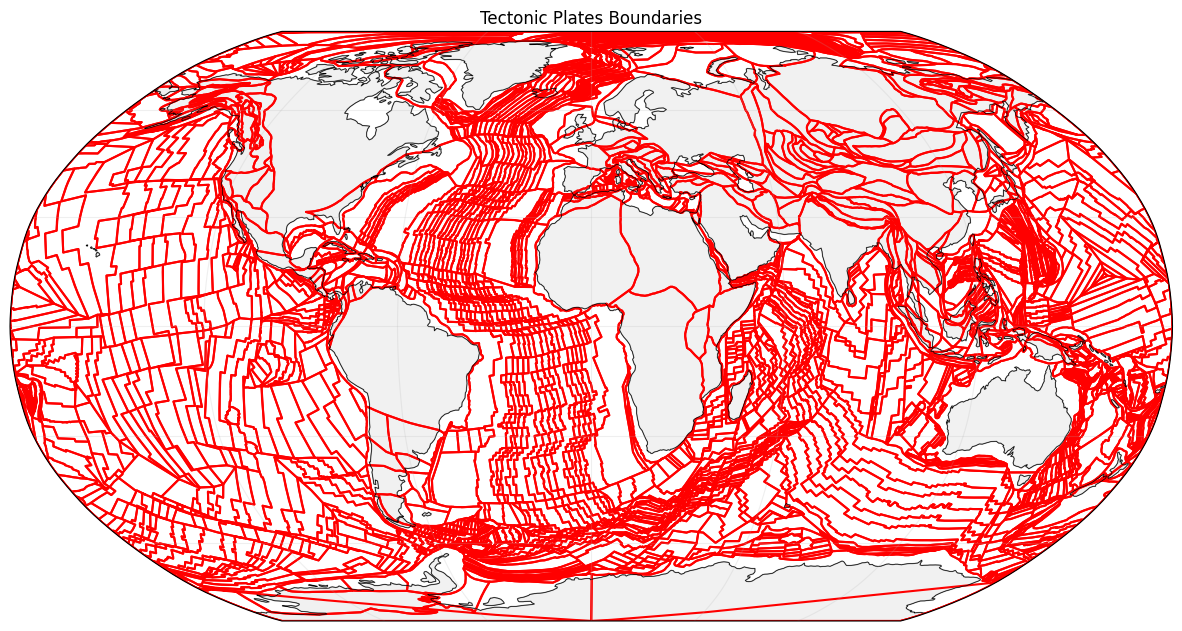

In [ ]:
create_plate_map(polygons)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Boundaries'}>)

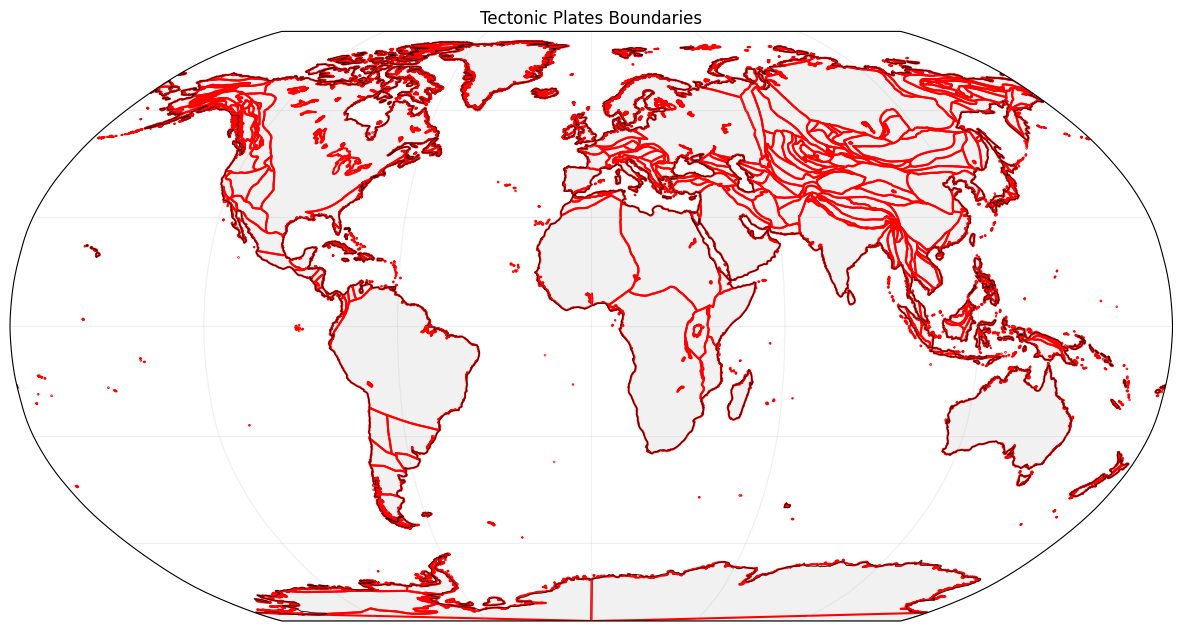

In [ ]:
create_plate_map(polygons)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Boundaries'}>)

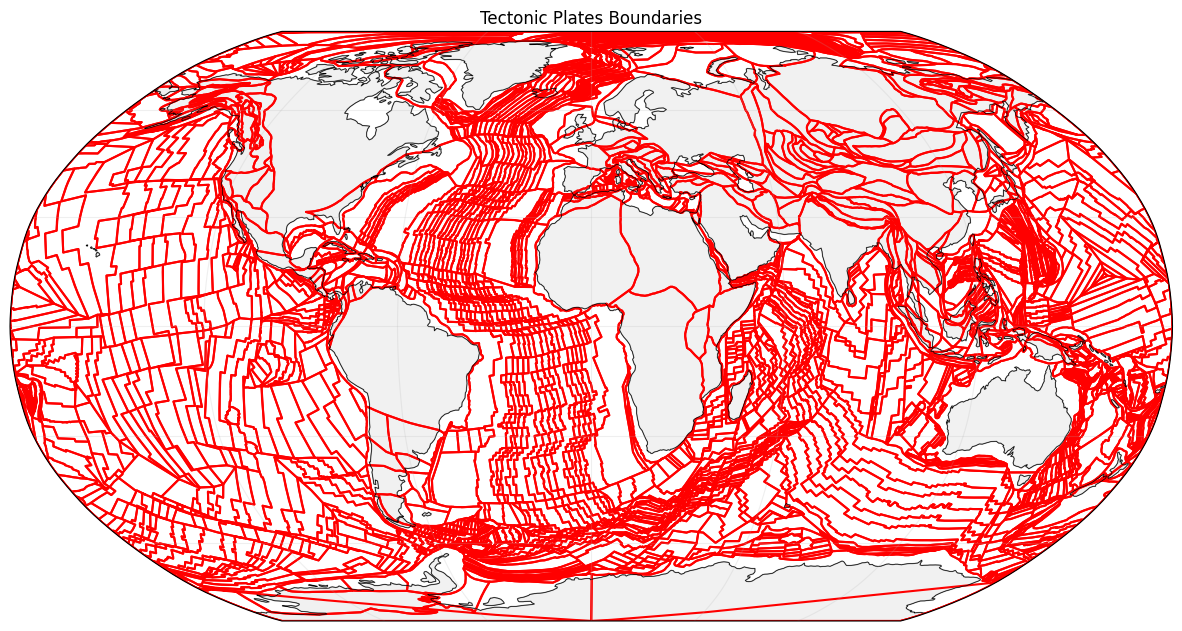

In [ ]:
create_plate_map(polygons)

In [ ]:
# Debug info
print(f"Number of polygons found: {len(polygons)}")
if polygons:
    # Print first few coordinates of first polygon
    first_poly_coords = list(polygons[0].exterior.coords)[:5]
    print(f"Sample coordinates from first polygon: {first_poly_coords}")

Number of polygons found: 2486
Sample coordinates from first polygon: [(32.346700000000055, -152.61909999999997), (29.601300000000037, -152.30609999999996), (28.800000000000065, -158.26219999999998), (23.92280000000006, -157.62339999999998), (24.041400000000067, -156.83159999999998)]


In [ ]:
print(f'Root: {len(root)}')
print(f'PosList: {len(root.findall(".//gml:posList", namespaces))}')
print(f'ReconstructionPlateIds: {len(root.findall(".//gpml:reconstructionPlateId//gpml:value", namespaces))}')

Root: 2471
PosList: 2486
PosList: 2471


In [ ]:
plateIds = [int(i.text) for i in root.findall(".//gpml:reconstructionPlateId//gpml:value", namespaces)]
print(len(set(plateIds)))

310


In [182]:
tree = ET.parse('/content/coastlines.gpml')
root = tree.getroot()
namespaces = {
    'gml': 'http://www.opengis.net/gml',
    'gpml': 'http://www.gplates.org/gplates'
}
features = root.findall('.//gml:featureMember', namespaces)

In [ ]:
majorPlateIds = {701, 101, 201, 301, 801, 802, 901}

In [ ]:
majorPlatePolygons = defaultdict(list)
for feature in features:
    assert len(feature) == 1
    feature = feature[0]

    plateIds = feature.findall(".//gpml:reconstructionPlateId//gpml:value", namespaces)
    if len(plateIds) == 0: continue
    plateId = int(plateIds[0].text)
    # if plateId not in majorPlateIds:
    #     continue

    positions = feature.findall('.//gml:posList', namespaces)
    for position in positions:
        position_list = position.text.split()
        coord_pairs = [(float(position_list[i+1]), float(position_list[i]))
                                for i in range(0, len(position_list), 2)]
        majorPlatePolygons[plateId].append(Polygon(coord_pairs))


majorPlatePolygons

In [ ]:
majorPlatePolygons[701]

In [210]:
rows = []
for feature in features:
    assert len(feature) == 1
    feature = feature[0]
    featureType = feature.tag.split('}')[1]

    plateIds = feature.findall(".//gpml:reconstructionPlateId//gpml:value", namespaces)
    if len(plateIds) == 0: continue
    plateId = int(plateIds[0].text)
    # if plateId not in majorPlateIds:
    #     continue

    name = feature.findall(".//gml:name", namespaces)[0].text
    begin = float(feature.findall(".//gml:validTime//gml:begin//gml:timePosition", namespaces)[0].text)
    end = feature.findall(".//gml:validTime//gml:end//gml:timePosition", namespaces)[0].text
    if end == 'http://gplates.org/times/distantFuture':
        end = 0.0
    else:
        end = float(end)

    polygons = []
    positions = feature.findall('.//gml:posList', namespaces)
    for position in positions:
        position_list = position.text.split()
        coord_pairs = [[float(position_list[i]), float(position_list[i+1])]
                                for i in range(0, len(position_list), 2)]
        polygons.append(coord_pairs)

    rows.append([featureType, polygons, plateId, name, begin, end])

print(rows[:5])

[['Basin', [[[19.85355599999994, -155.08441699999997], [19.729971999999975, -155.087806], [19.738222000000007, -155.00502799999998], [19.519139000000024, -154.80575], [19.346417000000088, -154.97772200000003], [19.136611000000016, -155.50566700000002], [18.913056000000097, -155.67533299999997], [18.998167000000024, -155.78688900000003], [19.085082999999997, -155.91097199999996], [19.346499999999935, -155.88933300000002], [19.72963900000005, -156.06461099999996], [19.98366699999994, -155.83116699999994], [20.197389000000015, -155.90624999999997], [20.27277799999996, -155.853389], [19.975000000000023, -155.210139], [19.85355599999994, -155.08441699999997]]], 901, 'Pacific', 0.4, 0.0], ['Basin', [[[21.033472000000103, -156.59055600000002], [20.899193999999937, -156.477194], [20.94591700000001, -156.25658299999998], [20.796971999999982, -156.002889], [20.698166999999984, -156.000583], [20.585750000000104, -156.41566700000004], [20.78416700000011, -156.46686100000002], [20.812722000000008, 

In [211]:
polygonDf = pd.DataFrame(rows, columns=['featureType', 'polygons', 'plateId', 'name', 'begin', 'end'])
polygonDf

featureType  \
0                         Basin   
1                         Basin   
2                         Basin   
3                         Basin   
4                         Basin   
...                         ...   
2072  ClosedContinentalBoundary   
2073  ClosedContinentalBoundary   
2074  ClosedContinentalBoundary   
2075  ClosedContinentalBoundary   
2076  ClosedContinentalBoundary   

                                               polygons  plateId  \
0     [[[19.85355599999994, -155.08441699999997], [1...      901   
1     [[[21.033472000000103, -156.59055600000002], [...      901   
2     [[[21.461527999999987, -157.723194], [21.31055...      901   
3     [[[21.960443999999995, -159.332444], [21.86891...      901   
4     [[[21.161944000000034, -156.710194], [21.05002...      901   
...                                                 ...      ...   
2072  [[[-76.29476333521959, -146.72900324038454], [...      804   
2073  [[[-37.862010722364616, 176.81236263750355], [...     8065   
2074  [[[-37.862010722364616, 176.81236263750355], [...     8064   
2075  [[[-41.7516182005166, 173.10610375500642], [-4...    80613   
2076  [[[-41.7516182005166, 173.10610375500642], [-4...     8069   

                          name  begin  end  
0                      Pacific    0.4  0.0  
1                      Pacific    1.3  0.0  
2                      Pacific    2.6  0.0  
3                      Pacific    5.1  0.0  
4                      Pacific    1.3  0.0  
...                        ...    ...  ...  
2072           Marie Byrd Land  600.0  0.0  
2073  North Island New Zealand  280.0  0.0  
2074  North Island New Zealand  280.0  0.0  
2075  North Island New Zealand  280.0  0.0  
2076  North Island New Zealand  280.0  0.0  

[2077 rows x 6 columns]

In [ ]:
polygons = polygonDf[(polygonDf['plateId'] == 701) & (polygonDf['begin'] == 600)]['polygons']
for i in polygons:
    for j in i:
        print(j[:5])

In [4]:
polygonDf.to_pickle('coastlinesDF.pkl')

NameError: name 'polygonDf' is not defined

In [5]:
polygonDf = pd.read_pickle('coastlinesDF.pkl')
polygonDf

featureType  \
0                         Basin   
1                         Basin   
2                         Basin   
3                         Basin   
4                         Basin   
...                         ...   
2072  ClosedContinentalBoundary   
2073  ClosedContinentalBoundary   
2074  ClosedContinentalBoundary   
2075  ClosedContinentalBoundary   
2076  ClosedContinentalBoundary   

                                               polygons  plateId  \
0     [[[19.85355599999994, -155.08441699999997], [1...      901   
1     [[[21.033472000000103, -156.59055600000002], [...      901   
2     [[[21.461527999999987, -157.723194], [21.31055...      901   
3     [[[21.960443999999995, -159.332444], [21.86891...      901   
4     [[[21.161944000000034, -156.710194], [21.05002...      901   
...                                                 ...      ...   
2072  [[[-76.29476333521959, -146.72900324038454], [...      804   
2073  [[[-37.862010722364616, 176.81236263750355], [...     8065   
2074  [[[-37.862010722364616, 176.81236263750355], [...     8064   
2075  [[[-41.7516182005166, 173.10610375500642], [-4...    80613   
2076  [[[-41.7516182005166, 173.10610375500642], [-4...     8069   

                          name  begin  end  
0                      Pacific    0.4  0.0  
1                      Pacific    1.3  0.0  
2                      Pacific    2.6  0.0  
3                      Pacific    5.1  0.0  
4                      Pacific    1.3  0.0  
...                        ...    ...  ...  
2072           Marie Byrd Land  600.0  0.0  
2073  North Island New Zealand  280.0  0.0  
2074  North Island New Zealand  280.0  0.0  
2075  North Island New Zealand  280.0  0.0  
2076  North Island New Zealand  280.0  0.0  

[2077 rows x 6 columns]

In [21]:
polygonDf['polygons'][0][0]

[[-155.08441699999997, 19.85355599999994],
 [-155.087806, 19.729971999999975],
 [-155.00502799999998, 19.738222000000007],
 [-154.80575, 19.519139000000024],
 [-154.97772200000003, 19.346417000000088],
 [-155.50566700000002, 19.136611000000016],
 [-155.67533299999997, 18.913056000000097],
 [-155.78688900000003, 18.998167000000024],
 [-155.91097199999996, 19.085082999999997],
 [-155.88933300000002, 19.346499999999935],
 [-156.06461099999996, 19.72963900000005],
 [-155.83116699999994, 19.98366699999994],
 [-155.90624999999997, 20.197389000000015],
 [-155.853389, 20.27277799999996],
 [-155.210139, 19.975000000000023],
 [-155.08441699999997, 19.85355599999994]]

In [ ]:
polygonDf[polygonDf['begin'] > 400]

featureType  \
30    ClosedContinentalBoundary   
31    ClosedContinentalBoundary   
32    ClosedContinentalBoundary   
33    ClosedContinentalBoundary   
34    ClosedContinentalBoundary   
...                         ...   
2068  ClosedContinentalBoundary   
2069  ClosedContinentalBoundary   
2070  ClosedContinentalBoundary   
2071  ClosedContinentalBoundary   
2072  ClosedContinentalBoundary   

                                               polygons  \
30    [[(-6.117758477092649, 36.2845134674848), (-6....   
31    [[(42.45775179821561, 38.722535028000266), (42...   
32    [[(56.278250000000014, 26.963028000000097), (5...   
33    [[(48.163306000000034, 29.982943999999947), (4...   
34    [[(58.95869400000004, 20.509166999999934), (58...   
...                                                 ...   
2068  [[(-44.068048218282826, 60.16576732957598), (-...   
2069  [[(-20.074240767276468, 77.61568150494996), (-...   
2070  [[(-20.074240767276468, 77.61568150494996), (-...   
2071  [[(-146.72900324038454, -76.29476333521959), (...   
2072  [[(-146.72900324038454, -76.29476333521959), (...   

      reconstructionPlateId             name  begin  end  
30                      329    Betic (Spain)  600.0  0.0  
31                      503           Arabia  600.0  0.0  
32                      503           Arabia  600.0  0.0  
33                      503           Arabia  600.0  0.0  
34                      503           Arabia  600.0  0.0  
...                     ...              ...    ...  ...  
2068                    102        Greenland  600.0  0.0  
2069                    102        Greenland  600.0  0.0  
2070                    102        Greenland  600.0  0.0  
2071                    804  Marie Byrd Land  600.0  0.0  
2072                    804  Marie Byrd Land  600.0  0.0  

[1229 rows x 6 columns]

In [ ]:
polygonList = [b for a in list(majorPlatePolygons.values()) for b in a]

In [ ]:
# invalidIdx = []
# for idx,p in enumerate(majorPlatePolygons):
#     if not p.is_valid:
#         print(idx)
#         print(p)
#         print(is_valid_reason(p))
#         invalidIdx.append(idx)

221
POLYGON ((180 -72.53001372699997, 0 -90, 0 -90, 0.2328591220000362 -69.72025669399996, 0.336900000000071 -69.72139999999996, 0.6289000000000441 -69.77759999999995, 0.976000000000056 -69.85539899999996, 1.29569900000007 -69.9362, 1.6600981280000724 -70.00624866199996, 1.6973000000000409 -70.01339999999995, 2.2529000000000683 -70.05279899999994, 2.8166990000000283 -70.04559999999998, 3.5258000000000616 -70.01949999999992, 4.280700000000024 -70.01499999999999, 4.917200000000038 -70.00449999999996, 5.4079000000000415 -69.97869899999995, 5.871300000000077 -69.94669999999996, 6.083088088000068 -69.92751486499998, 6.470600000000046 -69.88939899999995, 6.652299000000028 -69.87649899999997, 6.806800000000066 -69.86689999999997, 6.870200000000069 -69.85419999999995, 6.933400000000064 -69.82589899999994, 6.967265786000041 -69.81168549599994, 7.044612738000065 -69.77780777799995, 7.1860000000000355 -69.70889999999999, 7.267600000000072 -69.68989899999997, 7.321999000000062 -69.68339899999995, 

In [ ]:
# validMajorPlatePolygons = [majorPlatePolygons[i] for i in range(len(majorPlatePolygons)) if i not in invalidIdx]

In [ ]:
# mergedMajorPlates = unary_union(validMajorPlatePolygons)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

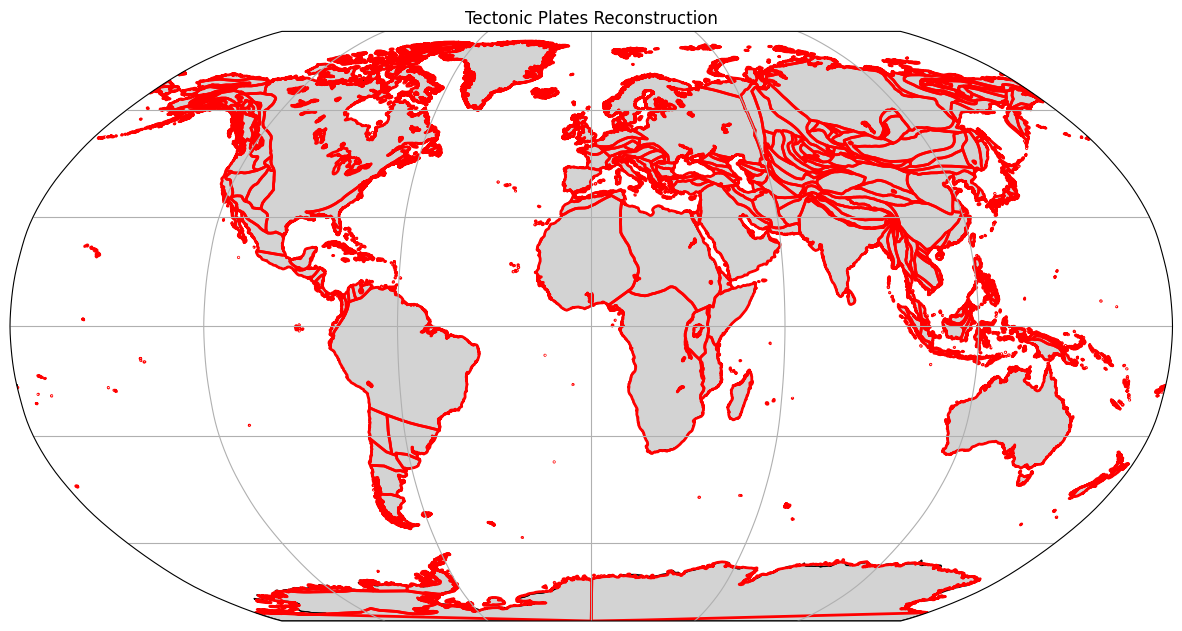

In [ ]:
#coastlines.gpml
create_plate_map(polygonList)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

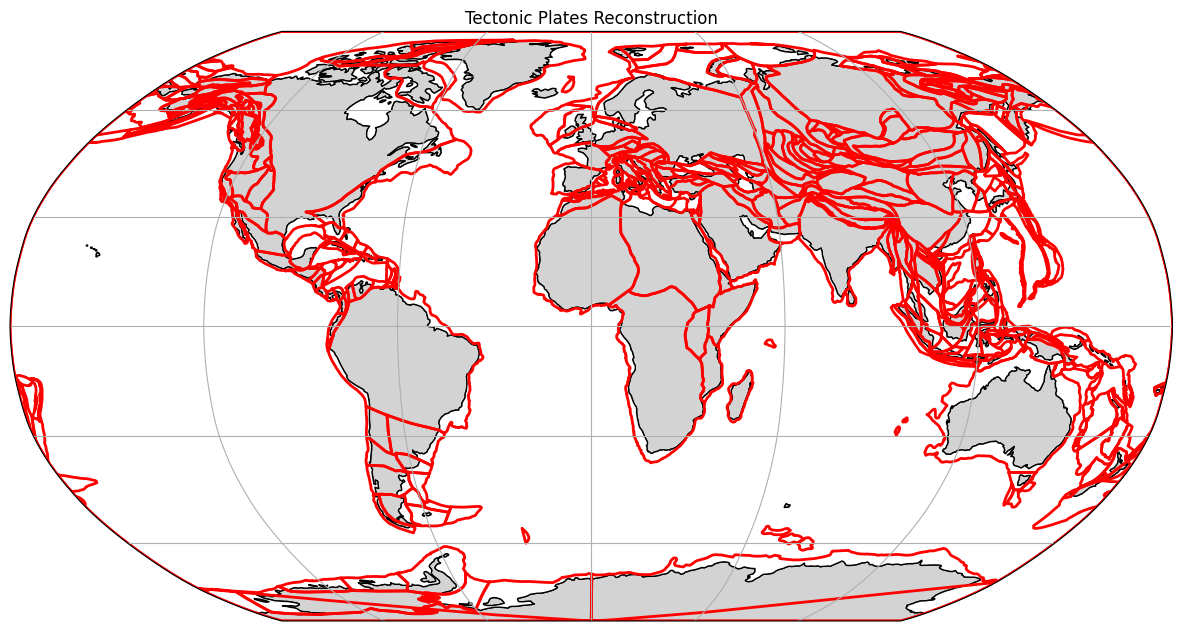

In [ ]:
#continents.gpml
create_plate_map(majorPlatePolygons)

In [119]:
rotationDf = pd.read_csv('rotation.rot',
                 delim_whitespace=True,
                 names=['moving_plate_id',
                       'age_ma',
                       'euler_pole_lat',
                       'euler_pole_lon',
                       'rotation_angle',
                       'fixed_plate_id'],
                 comment='!')
rotationDf

<ipython-input-119-11bbe0f7a0e9>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rotationDf = pd.read_csv('rotation.rot',


moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
0                    0     0.0            0.00            0.00   
1                    0     1.0           25.92         -127.66   
2                    0     2.0           25.97         -127.99   
3                    0     3.0           26.45         -128.75   
4                    0     4.0           28.07         -129.24   
...                ...     ...             ...             ...   
37359        926742001     0.0          -47.07          162.22   
37360        926742001   120.6          -47.07          162.22   
37361        926742001   125.0          -39.88          147.65   
37362        926742001   140.5           90.00            0.00   
37363        926742001  3000.0           90.00            0.00   

       rotation_angle  fixed_plate_id  
0                0.00          666666  
1                0.02          666666  
2                0.05          666666  
3                0.07          666666  
4                0.09          666666  
...               ...             ...  
37359            2.50       897142001  
37360            2.50       897142001  
37361            1.51       897142001  
37362            0.00       897142001  
37363            0.00       897142001  

[37364 rows x 6 columns]

In [107]:
for (low,up), (min,max) in rotationDf.groupby(['moving_plate_id', 'fixed_plate_id'])['age_ma'].agg(['min', 'max']).iterrows():
    print(low,up)
    print(min,max)
    break

0 666666
0.0 411.0


In [63]:
dg = nx.DiGraph()

In [115]:
for (movingPlateId,fixedPlateId), (minAge,maxAge) in rotationDf.groupby(['moving_plate_id', 'fixed_plate_id'])['age_ma'].agg(['min', 'max']).iterrows():
    if movingPlateId == 501 and fixedPlateId == 802:
        print('here')
        print(movingPlateId,fixedPlateId)
        print(minAge,maxAge)
    dg.add_edge(movingPlateId, fixedPlateId, minAge=minAge, maxAge=maxAge)

here
501 802
125.7 600.0


In [117]:
dg[501][802]['']

{'minAge': 125.7, 'maxAge': 600.0}

In [120]:
rotationDf[(rotationDf['moving_plate_id'] == 501) & (rotationDf['fixed_plate_id'] == 802)]

moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
2400               501   125.7          0.7741       -170.1134   
2401               501   127.8          1.1929       -169.3237   
2402               501   128.3          1.3526       -169.1836   
2403               501   136.0          2.6995       -167.1237   
2404               501   160.0          3.5975       -165.8037   
2405               501   250.0          3.5975       -165.8037   
24662              501   250.0          3.6400       -165.7900   
24663              501   600.0          3.6400       -165.7900   

       rotation_angle  fixed_plate_id  
2400          85.0504             802  
2401          85.4296             802  
2402          85.6894             802  
2403          87.3970             802  
2404          88.3953             802  
2405          88.3953             802  
24662         88.2800             802  
24663         88.2800             802

KeyboardInterrupt: 

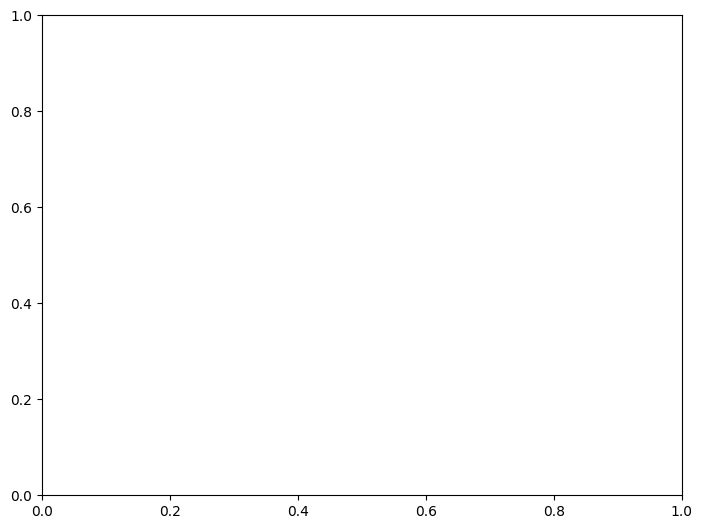

In [ ]:
# nx.draw(dg, with_labels=True, font_weight='bold')

In [ ]:
for p in majorPlateIds:
    print(f'Shortest path from {p} to 666666:')
    print(nx.shortest_path(dg, source=p, target=666666))

Shortest path from 801 to 666666:
[801, 802.0, 701.0, 0.0, 666666.0]
Shortest path from 802 to 666666:
[802, 701.0, 0.0, 666666.0]
Shortest path from 101 to 666666:
[101, 714.0, 715.0, 701.0, 0.0, 666666.0]
Shortest path from 901 to 666666:
[901, 0.0, 666666]
Shortest path from 701 to 666666:
[701, 0.0, 666666.0]
Shortest path from 201 to 666666:
[201, 701.0, 0.0, 666666]
Shortest path from 301 to 666666:
[301, 101.0, 714.0, 715.0, 701.0, 0.0, 666666]


In [ ]:
print(nx.shortest_path(dg, source=501, target=0))
print(rotationDf[rotationDf['moving_plate_id'] == 501])
print(rotationDf[rotationDf['moving_plate_id'] == 511])
print(rotationDf[rotationDf['moving_plate_id'] == 701])
print(rotationDf[rotationDf['moving_plate_id'] == 0])

In [213]:
print(dg.in_degree(501))
print(list(dg.predecessors(501)))

53
[502.0, 511.0, 514.0, 704.0, 762.0, 763.0, 765.0, 767.0, 774.0, 775.0, 778.0, 779.0, 896.0, 7007.0, 7013.0, 7142.0, 7143.0, 7147.0, 7148.0, 7152.0, 7153.0, 7157.0, 7158.0, 7162.0, 7163.0, 7168.0, 7172.0, 7173.0, 7177.0, 7178.0, 7179.0, 7182.0, 7183.0, 7191.0, 7195.0, 7196.0, 7198.0, 7200.0, 7202.0, 7205.0, 7206.0, 7207.0, 7208.0, 7210.0, 7222.0, 7250.0, 7272.0, 7302.0, 7303.0, 569.0, 575.0, 529.0, 59004.0]


Convert lat,lon to 3d cartesian coordinates

1.   x = how far away from the merdian that is north-south at Grenwich. 0 at grenwich and 180 on the opposite side of grenwich on a globe
2.   At 90°E: y = 1 , At 90°W: y = -1, At 0° or 180°: y = 0
3.   z = latitude

x,y together give you longitude. x gives you east/west hemisphere. but for a value like 150 you could be 150 on east/west hemisphere WITH THIS SCHEMA. y singles out the correct one according to -90 to 90 hemispheres.

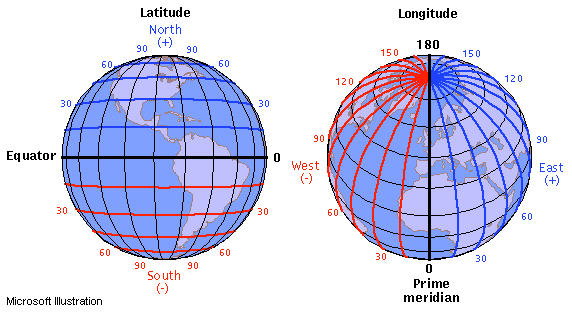


Euler Poles

A point on earth that tells you a plateid rotated along the euler pole at a certain angle some time ago. visually imagine the pole as the center of a clock and a line to the plate. move the plate like a clock hand some angle to get its location some time ago.

Points further from the euler pole move a greater distance than points very close to the euler pole. you can visualize this. this is because the circle formed by points further away is much greater than the circle formed by points close to the circle.

a way to describe these circles is through degrees. using degrees as a unit of measure is already done with regards to latitude and longitude. however we can also use them to describe the circles of points relative to the euler pole.

imagine you are standing at the center of the earth. you are looking directly at the euler pole. you are looking straight up at 90 degrees at the pole. then look 45 degrees to the right by tilting your head. then 45 degrees left, up and down. if you took those points and drew a circle through them, that would be the circle formed by looking at 45 degrees away from the euler pole.

we can describe this as a 45 degree circle in reference to the euler pole. we can do this for 90 degree circles and anything else. bigger degree circles like 90 degree circles move much further distances than 45 degree circles for the same euler pole angle movement as specificied in a rotation file.

rotation matrices. worked em out on paper and takes a little bit to understand why certain rotation matrices do things but not hard. write some out on paper if confused.

correct order of rotation matrix - rotate such that euler pole is at prime meridian (adjust lon) then rotate up to north pole. this is the correct order. intuitively the other one seems a little messier if you rotate up to the north pole then twist the globe around to get correct lon. doesnt make 100% sense to me right now but will figure out. i guess if you rotate up the lon that are now on new places in the globe are not correct distances from each other since lon are closer the more towards the poles you are and it's more complicated to rotate?

rotate prime meridian
[ cos(θ)  -sin(θ)   0   ]
[ sin(θ)   cos(θ)   0   ]
[   0        0      1   ]

if angle small keep most of x same and subtract some y | keep most of x and subtract most of y.

rotate up to north pole
[ cos(α)   0   sin(α) ]
[   0      1     0    ]
[-sin(α)   0   cos(α) ]

Euler-Rodrigues rotation formula

basically identifies that when rotating an object there are 2 different motions really at work.

imagine you have a spinning top. if you look at any point on the top, the height never changes. however the location of the point does change and traces a circle along the center of the top.

you can imagine the rotation axis as the line along which the top turns which is directly perpendicular to the floor straight up through the center of the top.

thats the rotation axis. now imagine a bunch of lines parallel to the rotation axis. so for every point on the circle, perpendicular to the floor underneath, through the point, above the top. these represent the parallel components of the rotation.

what this means is that every point never has their position on the parallel component change. if a point on the top starts at height 3 on a particular parallel component, it will rotate along the top and always be height 3.

however as it turns around the circle, it will intersect different parallel lines. this is because as it rotates it moves perpendicular to the parallel lines. it moves from parallel line to parallel line. while the height will be the same along each of these, it will be at a different parallel line.

this direction of movement is the perpendicular component.

so the parallel component, the height, never changes but which parallel line you're on, the perpendicular component is what actually changes in the rotation.

another note, the further out a point is from the center of the top, which is the perpendicular component. imagine the rotation axis line. draw a line perpendicular to that to some point on the top. the larger the perpendicular component, the larger circle it will draw as it rotates. the smaller the perpendicular component, the smaller circle as it rotates.

In [20]:
def create_rotation_matrix(k, theta):
    """
    Create a 3D rotation matrix for rotation around axis k by angle theta.

    Parameters:
    k (np.array): Axis of rotation (will be normalized)
    theta (float): Rotation angle in radians

    Returns:
    np.array: 3x3 rotation matrix
    """
    # Normalize the rotation axis
    k = k / np.linalg.norm(k)
    kx, ky, kz = k

    # Compute cos and sin of theta
    c = np.cos(theta)
    s = np.sin(theta)
    C = 1 - c

    # Create the rotation matrix
    R = np.array([
        [kx*kx*C + c,    kx*ky*C - kz*s,  kx*kz*C + ky*s],
        [ky*kx*C + kz*s,  ky*ky*C + c,    ky*kz*C - kx*s],
        [kz*kx*C - ky*s,  kz*ky*C + kx*s,  kz*kz*C + c]
    ])

    return R

def rotate_points(points, k, theta):
    """
    Rotate multiple points around axis k by angle theta.

    Parameters:
    points (np.array): Nx3 array of points to rotate
    k (np.array): Axis of rotation
    theta (float): Rotation angle in radians

    Returns:
    np.array: Nx3 array of rotated points
    """
    R = create_rotation_matrix(k, theta)
    # Use matrix multiplication to rotate all points at once
    rotated_points = np.dot(points, R.T)  # right to left multiplication
    return rotated_points

In [22]:
import numpy as np
from scipy.linalg import logm, expm

def slerp_rotation_matrices(R1, R2, t):
    """
    SLERP interpolation between two rotation matrices.
    Args:
        R1, R2: 3x3 rotation matrices
        t: Interpolation parameter (0 to 1)
    Returns:
        Interpolated rotation matrix
    """
    if t == 0: return R1
    if t == 1: return R2

    # Compute relative rotation
    R = R1.T @ R2

    # Convert to axis-angle representation
    cos_theta = np.clip((np.trace(R) - 1) / 2, -1, 1)
    theta = np.arccos(cos_theta)
    if abs(theta) < 1e-10:
        return R1

    log_R = theta * (R - R.T) / (2 * np.sin(theta))

    # Interpolate
    return R1 @ expm(t * log_R)

In [ ]:
# Example usage:
points = np.array([
    [3, 0, 0],
    [0, 3, 0],
    [0, 0, 3]
])  # 3 points to rotate
k = np.array([1, 1, 1])  # rotation axis
theta = np.pi/4  # 45 degrees

# Rotate all points at once
rotated_points = rotate_points(points, k, theta)
print(rotated_points)

[[ 2.41421356  1.51763809 -0.93185165]
 [-0.93185165  2.41421356  1.51763809]
 [ 1.51763809 -0.93185165  2.41421356]]


In [ ]:
# Example usage:
points = np.array([
    [[1, 0, 0], [0, 1, 0], [0, 0, 1]],  # polygon 1
    [[2, 0, 0], [0, 2, 0], [0, 0, 2]],  # polygon 2
    [[3, 0, 0], [0, 3, 0], [0, 0, 3]]   # polygon 3
])
k = np.array([1, 1, 1])  # rotation axis
theta = np.pi/4  # 45 degrees

# Rotate all points at once
rotated_points = rotate_points(points, k, theta)
print(rotated_points)

[[[ 0.80473785  0.50587936 -0.31061722]
  [-0.31061722  0.80473785  0.50587936]
  [ 0.50587936 -0.31061722  0.80473785]]

 [[ 1.60947571  1.01175873 -0.62123444]
  [-0.62123444  1.60947571  1.01175873]
  [ 1.01175873 -0.62123444  1.60947571]]

 [[ 2.41421356  1.51763809 -0.93185165]
  [-0.93185165  2.41421356  1.51763809]
  [ 1.51763809 -0.93185165  2.41421356]]]


In [23]:
def latlon_to_xyz(points):
    """
    Convert latitude/longitude coordinates to 3D Cartesian coordinates on a unit sphere.

    Parameters:
    points (np.array): Nx2 array of [latitude, longitude] pairs in degrees

    Returns:
    np.array: Nx3 array of [x, y, z] coordinates
    """
    # Convert degrees to radians
    lat_rad = np.radians(points[:, 0])
    lon_rad = np.radians(points[:, 1])

    # Convert to 3D coordinates
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)

    # Stack coordinates into Nx3 array
    xyz = np.column_stack((x, y, z))
    return xyz

def xyz_to_latlon(points):
    """
    Convert 3D Cartesian coordinates back to latitude/longitude.

    Parameters:
    points (np.array): Nx3 array of [x, y, z] coordinates

    Returns:
    np.array: Nx2 array of [latitude, longitude] pairs in degrees
    """
    # Normalize the vectors
    norm = np.sqrt(np.sum(points**2, axis=1))
    points = points / norm[:, np.newaxis]

    # Convert to lat/lon
    lat = np.degrees(np.arcsin(points[:, 2]))
    lon = np.degrees(np.arctan2(points[:, 1], points[:, 0]))

    return np.column_stack((lat, lon))

In [ ]:
# Example usage:
points = np.array([
    [45, -120],  # lat, lon pairs in degrees
    [30, 60],
    [-15, 10]
])
print(f'Points: {points}')
# Convert to 3D coordinates
xyz_points = latlon_to_xyz(points)
print(f'XYZ Points: {xyz_points}')
# Define rotation (e.g., around pole at 45°N, 90°E by 30 degrees)
pole = np.array([45, 90])  # lat, lon of Euler pole
pole_xyz = latlon_to_xyz(pole.reshape(1, 2))[0]  # convert pole to 3D
angle = np.radians(30)  # rotation angle in radians

# Rotate the points
rotated_xyz = rotate_points(xyz_points, pole_xyz, angle)
print(f'Rotated XYZ Points: {rotated_xyz}')

# Convert back to lat/lon
rotated_latlon = xyz_to_latlon(rotated_xyz)
print(f'Rotated Lat/Lon Points: {rotated_latlon}')

Points: [[  45 -120]
 [  30   60]
 [ -15   10]]
XYZ Points: [[-0.35355339 -0.61237244  0.70710678]
 [ 0.4330127   0.75        0.5       ]
 [ 0.95125124  0.16773126 -0.25881905]]
Rotated XYZ Points: [[ 0.16032013 -0.64898409  0.74371843]
 [ 0.28661165  0.88634628  0.36365372]
 [ 0.67299943  0.47547591 -0.56656369]]
Rotated Lat/Lon Points: [[ 48.04913986 -76.12389405]
 [ 21.32475353  72.08070847]
 [-34.51094767  35.24130841]]


In [ ]:
print(majorPlatePolygons[701][0])
print(list(majorPlatePolygons[701][0].exterior.coords))

POLYGON ((-12.217083000000002 -37.13336100000002, -12.284999999999968 -37.198778000000004, -12.35544399999994 -37.14, -12.30169399999994 -37.07544400000003, -12.217083000000002 -37.13336100000002))
[(-12.217083000000002, -37.13336100000002), (-12.284999999999968, -37.198778000000004), (-12.35544399999994, -37.14), (-12.30169399999994, -37.07544400000003), (-12.217083000000002, -37.13336100000002)]


In [ ]:
pole1 = rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['age_ma'] == 400)]
pole1LatLon = np.array(pole1[['euler_pole_lat', 'euler_pole_lon']])
rotationAnglePole1 = np.radians(pole1['rotation_angle'].values[0])
pole2 = rotationDf[(rotationDf['moving_plate_id'] == 0) & (rotationDf['age_ma'] == 400)]
pole2LatLon = np.array(pole2[['euler_pole_lat', 'euler_pole_lon']])
rotationAnglePole2 = np.radians(pole2['rotation_angle'].values[0])

print(f'Pole 1 Row: {pole1}')
print(f'Pole 2 Row: {pole2}')
print('\n')
print(f'Pole 1 Lat Lon: {pole1LatLon}')
print(f'Pole 2 Lat Lon: {pole2LatLon}')
print('\n')
print(f'Pole 1 Rotation Angle: {pole1["rotation_angle"].values[0]} -> {rotationAnglePole1}')
print(f'Pole 2 Rotation Angle: {pole2["rotation_angle"].values[0]} -> {rotationAnglePole2}')

Pole 1 Row:        moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
24968              701   400.0         46.6956        105.5812   

       rotation_angle  fixed_plate_id  
24968         38.2864               0  
Pole 2 Row:      moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  rotation_angle  \
400                0   400.0           22.58          158.26           28.33   

     fixed_plate_id  
400          666666  


Pole 1 Lat Lon: [[ 46.6956 105.5812]]
Pole 2 Lat Lon: [[ 22.58 158.26]]


Pole 1 Rotation Angle: 38.2864 -> 0.668223738735557
Pole 2 Rotation Angle: 28.33 -> 0.49445177708999355


In [ ]:
rotatedPolygons = []
for row, p in polygonDf[polygonDf['plateId'] == 701].iterrows():
    polygon = np.array(p['polygons'][0])
    xyz_polygon = latlon_to_xyz(polygon)

    pole1_xyz = latlon_to_xyz(pole1LatLon)[0]
    pole2_xyz = latlon_to_xyz(pole2LatLon)[0]

    rotation1_xyz = rotate_points(xyz_polygon, pole1_xyz, rotationAnglePole1)
    rotation2_xyz = rotate_points(rotation1_xyz, pole2_xyz, rotationAnglePole2)

    rotated_latlon = xyz_to_latlon(rotation2_xyz)

    rotatedPolygons.append(Polygon(rotated_latlon))

print(rotatedPolygons)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

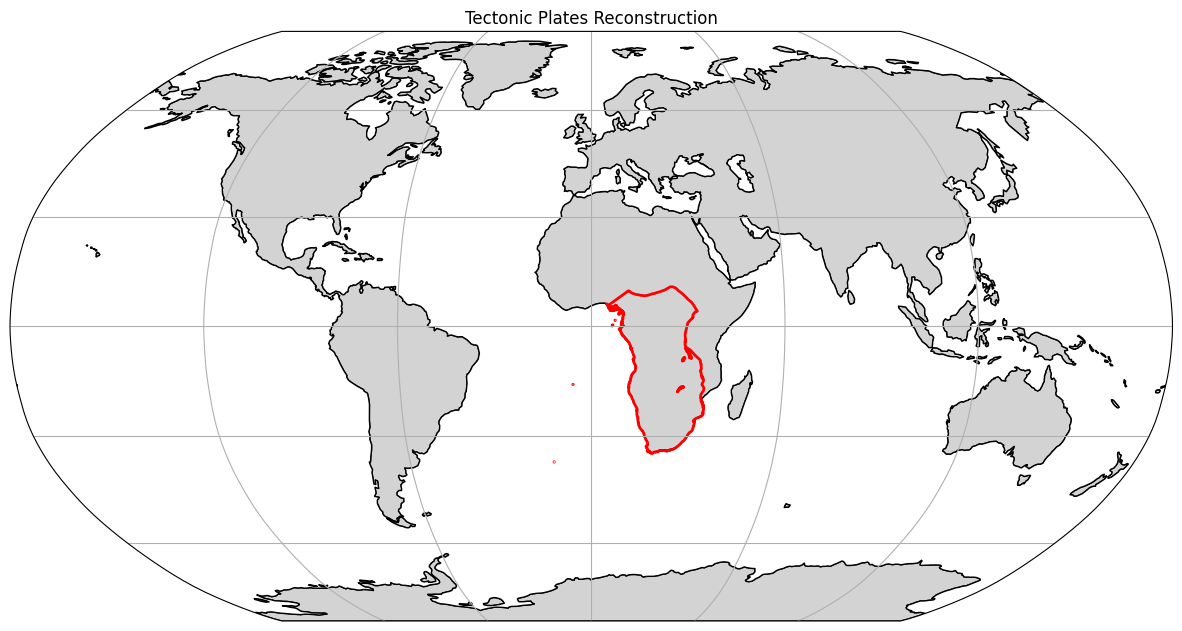

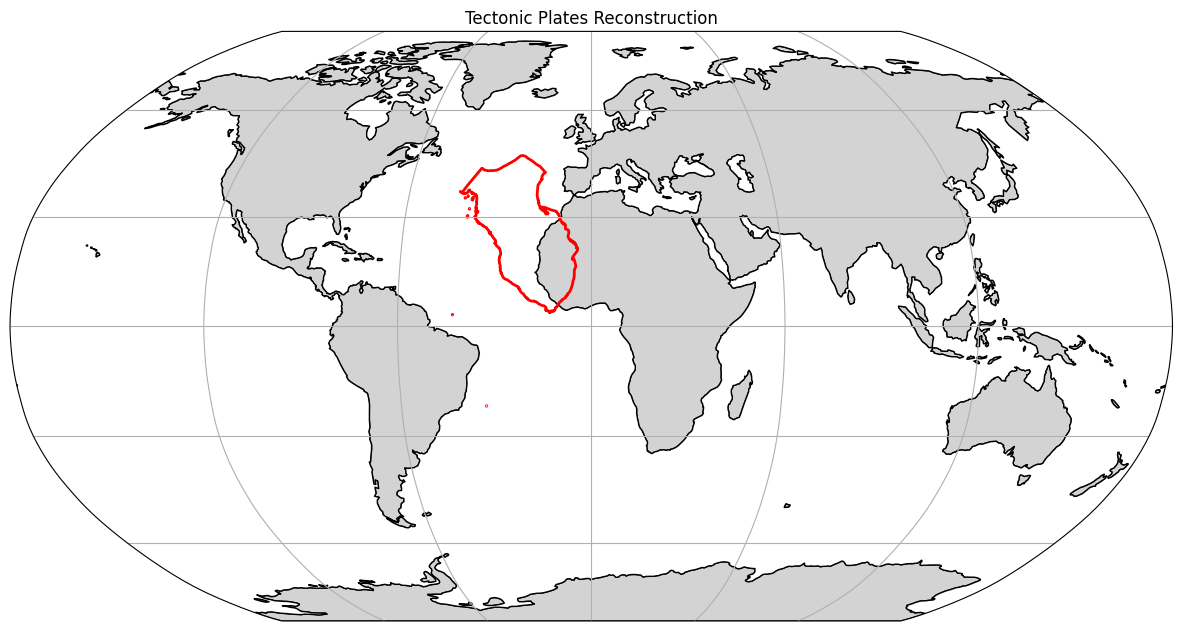

In [ ]:
create_plate_map(majorPlatePolygons[701])
create_plate_map(rotatedPolygons)

In [85]:
rotatedPolygons = []
reconstructionTime = 400
for row,plate in polygonDf[polygonDf['begin'] > reconstructionTime].iterrows():
    rotationPath = nx.shortest_path(dg, source=plate['plateId'], target=0)
    print(rotationPath)
    for polygon in plate['polygons']:
        geometry = np.array(polygon)
        xyz_polygon = latlon_to_xyz(geometry)

        for plateIdx in range(0, len(rotationPath)-1):
            pole1 = rotationDf[(rotationDf['moving_plate_id'] == rotationPath[plateIdx]) & (rotationDf['age_ma'] == reconstructionTime)]
            # pole1LatLon = np.array(pole1[['euler_pole_lat', 'euler_pole_lon']])
            # rotationAnglePole1 = np.radians(pole1['rotation_angle'].values[0])
            # pole_xyz = latlon_to_xyz(pole1LatLon)[0]
            print(rotationPath[plateIdx], rotationPath[plateIdx+1])

    break

[329, 715.0, 701.0, 0.0]
329 715.0
715.0 701.0
701.0 0.0


In [ ]:
# print(rotationDf[(rotationDf['moving_plate_id'] == 329) & (rotationDf['age_ma'] > 400)])
rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['age_ma'] < 400)].sort_values(by='age_ma', ascending=True).iloc[-1]

moving_plate_id    701.0000
age_ma             395.0000
euler_pole_lat      43.5762
euler_pole_lon     106.2316
rotation_angle      38.1437
fixed_plate_id       0.0000
Name: 24967, dtype: float64

In [ ]:
rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['age_ma'] == 400)].empty

False

In [131]:
examplePolygon = np.array(polygonDf[(polygonDf['plateId'] == 501) & (polygonDf['begin'] > 400)].iloc[0]['polygons'][0])
# examplePolygon

In [ ]:
polygonDf[(polygonDf['plateId'] == 701) & (polygonDf['begin'] > 400)].iloc[0]['polygons']

In [ ]:
rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['age_ma'] == 397)]

Empty DataFrame
Columns: [moving_plate_id, age_ma, euler_pole_lat, euler_pole_lon, rotation_angle, fixed_plate_id]
Index: []

In [ ]:
rotationDf

moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
0                    0     0.0            0.00            0.00   
1                    0     1.0           25.92         -127.66   
2                    0     2.0           25.97         -127.99   
3                    0     3.0           26.45         -128.75   
4                    0     4.0           28.07         -129.24   
...                ...     ...             ...             ...   
37359        926742001     0.0          -47.07          162.22   
37360        926742001   120.6          -47.07          162.22   
37361        926742001   125.0          -39.88          147.65   
37362        926742001   140.5           90.00            0.00   
37363        926742001  3000.0           90.00            0.00   

       rotation_angle  fixed_plate_id  
0                0.00          666666  
1                0.02          666666  
2                0.05          666666  
3                0.07          666666  
4                0.09          666666  
...               ...             ...  
37359            2.50       897142001  
37360            2.50       897142001  
37361            1.51       897142001  
37362            0.00       897142001  
37363            0.00       897142001  

[37364 rows x 6 columns]

In [25]:
def plotRotatedPolygon(plateId, fixedPlateId, originalPolygon, reconstructionYear):
    # find path of rotations with graph
    # interpolate if needed
    # multiply adjacent rotation matrices
    # convert points to xyz
    # multiply by product of rotation matrices
    # back to lat lon
    if not rotationDf[(rotationDf['moving_plate_id'] == plateId) & (rotationDf['fixed_plate_id'] == fixedPlateId) & (rotationDf['age_ma'] == reconstructionYear)].empty:
        # print('not empty')
        row = rotationDf[(rotationDf['moving_plate_id'] == plateId) & (rotationDf['fixed_plate_id'] == fixedPlateId) & (rotationDf['age_ma'] == reconstructionYear)].iloc[0]
        rotatedPoints = xyz_to_latlon(
            rotate_points(
                latlon_to_xyz(originalPolygon),
                latlon_to_xyz(np.array(row[['euler_pole_lat', 'euler_pole_lon']]).reshape(1,2))[0],
                np.radians(row['rotation_angle'])
            )
        )

    else:
        # print('empty')
        # print(rotationDf[(rotationDf['moving_plate_id'] == plateId)].sort_values(by='age_ma', ascending=True))
        lowerRow = rotationDf[(rotationDf['moving_plate_id'] == plateId) & (rotationDf['fixed_plate_id'] == fixedPlateId) & (rotationDf['age_ma'] < reconstructionYear)].sort_values(by='age_ma', ascending=True)
        upperRow = rotationDf[(rotationDf['moving_plate_id'] == plateId) & (rotationDf['fixed_plate_id'] == fixedPlateId) & (rotationDf['age_ma'] > reconstructionYear)].sort_values(by='age_ma', ascending=True)
        if lowerRow.empty or upperRow.empty:
            print(f'{plateId}->{fixedPlateId}')
            print('something was empty!')
            return originalPolygon

        lowerRow = lowerRow.iloc[-1]
        upperRow = upperRow.iloc[0]

        interpolatedRotationMatrix = slerp_rotation_matrices(
            create_rotation_matrix(
                latlon_to_xyz(np.array(lowerRow[['euler_pole_lat', 'euler_pole_lon']]).reshape(1,2))[0],
                np.radians(lowerRow['rotation_angle'])
            ),
            create_rotation_matrix(
                latlon_to_xyz(np.array(upperRow[['euler_pole_lat', 'euler_pole_lon']]).reshape(1,2))[0],
                np.radians(upperRow['rotation_angle'])
            ),
            (reconstructionYear - lowerRow['age_ma']) / (upperRow['age_ma'] - lowerRow['age_ma'])
        )
        rotatedPoints = xyz_to_latlon(
            np.dot(latlon_to_xyz(originalPolygon), interpolatedRotationMatrix.T)
        )


    # create_plate_map([Polygon(rotatedPoints)], f'{reconstructionYear} Rotation')
    return rotatedPoints

In [129]:
def filterEdgeForAge(age):
    def filter_edge(n1, n2):
        return dg[n1][n2].get("minAge") < age < dg[n1][n2].get("maxAge")

    return filter_edge

def rotatePolygonWithRelativePlates(plateId, originalPolygon, reconstructionYear):
    # this subgraph should be input to func since multiple calls to same reconstructionYear for multiple plates
    subgraph = nx.subgraph_view(dg, filter_edge=filterEdgeForAge(reconstructionYear))
    path = nx.shortest_path(subgraph, source=plateId, target=0)
    rotatedPolygon = originalPolygon
    for i in range(0, len(path)-1):
        rotatedPolygon = plotRotatedPolygon(path[i], path[i+1], rotatedPolygon, reconstructionYear)

    return rotatedPolygon

In [133]:
rotatedPolygons = []
reconstructionTime = 100
for row,plate in polygonDf[polygonDf['begin'] > reconstructionTime].iterrows():
    for polygon in plate['polygons']:
        rotated = rotatePolygonWithRelativePlates(plate['plateId'], np.array(polygon), reconstructionTime)
        lonLat = [[i[1],i[0]] for i in rotated]
        rotatedPolygons.append(lonLat)

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


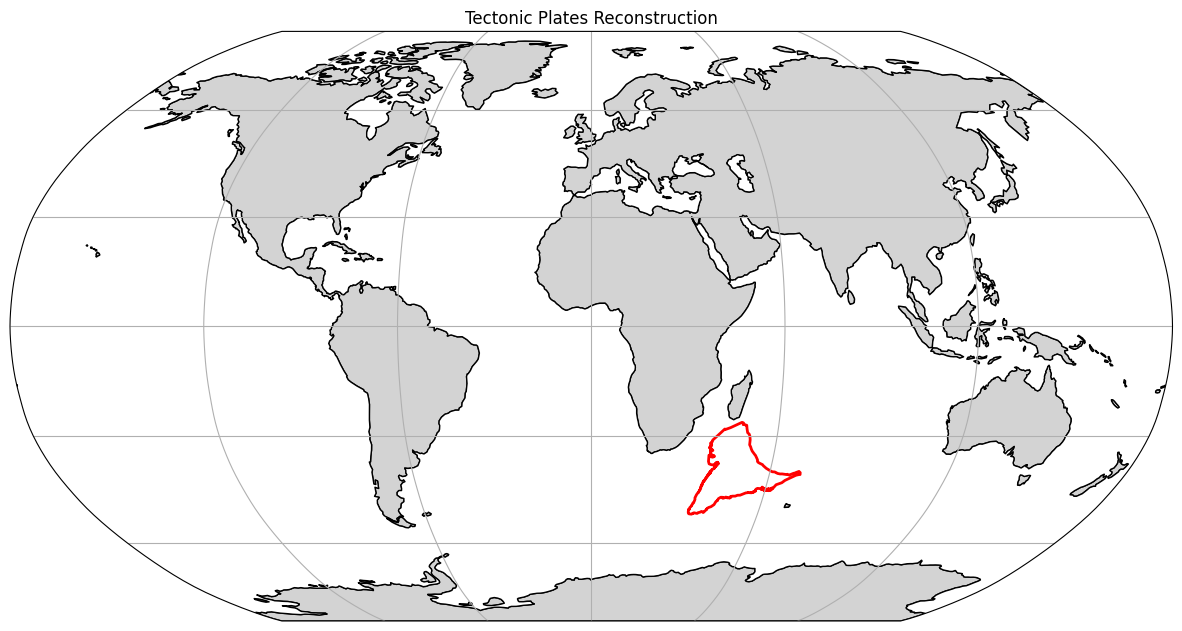

In [130]:
rotatedPolygon = rotatePolygonWithRelativePlates(501, examplePolygon, 100)
lonLat = [[i[1],i[0]] for i in rotatedPolygon]
create_plate_map([Polygon(lonLat)])

In [110]:
print(nx.shortest_path(dg, source=501, target=0))
print(list(nx.all_shortest_paths(dg, source=501, target=0)))

[501, 511.0, 701.0, 0]
[[501, 511.0, 701.0, 0], [501, 802.0, 701.0, 0]]


In [55]:
rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['fixed_plate_id'] == 0)]

moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
3189               701     0.0         90.0000          0.0000   
3190               701     5.0         51.5165        -80.0171   
3191               701    10.0         51.1400        -80.1100   
3192               701    15.0         54.0267        -72.2735   
3193               701    20.0         55.3100        -67.5700   
...                ...     ...             ...             ...   
24994              701   530.0         18.5631         83.3521   
24995              701   535.0         19.3089         79.1546   
24996              701   540.0         19.9551         74.9159   
24997              701   545.0         20.0200         71.8627   
24998              701   550.0         20.0211         68.6971   

       rotation_angle  fixed_plate_id  
3189           0.0000               0  
3190          -1.5599               0  
3191          -3.1200               0  
3192          -4.3329               0  
3193          -5.5700               0  
...               ...             ...  
24994         87.9628               0  
24995         83.6921               0  
24996         79.4597               0  
24997         77.2321               0  
24998         75.0751               0  

[112 rows x 6 columns]

In [127]:
def filterEdgeForAge(age):
    def filter_edge(n1, n2):
        return dg[n1][n2].get("minAge") < age < dg[n1][n2].get("maxAge")

    return filter_edge

subgraph = nx.subgraph_view(dg, filter_edge=filterEdgeForAge(400))

In [128]:
(501, 802) in subgraph.edges()

True

In [123]:
print(list(nx.all_shortest_paths(dg, source=501, target=0)))
print(list(nx.all_shortest_paths(subgraph, source=501, target=0)))

[[501, 511.0, 701.0, 0], [501, 802.0, 701.0, 0]]
[[501, 802.0, 701.0, 0]]


In [95]:
rotationDf[(rotationDf['moving_plate_id'] == 501) & (rotationDf['fixed_plate_id'] == 802)]
# rotationDf[(rotationDf['moving_plate_id'] == plateId) & (rotationDf['fixed_plate_id'] == fixedPlateId) & (rotationDf['age_ma'] < reconstructionYear)].sort_values(by='age_ma', ascending=True)

moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
2400               501   125.7          0.7741       -170.1134   
2401               501   127.8          1.1929       -169.3237   
2402               501   128.3          1.3526       -169.1836   
2403               501   136.0          2.6995       -167.1237   
2404               501   160.0          3.5975       -165.8037   
2405               501   250.0          3.5975       -165.8037   
24662              501   250.0          3.6400       -165.7900   
24663              501   600.0          3.6400       -165.7900   

       rotation_angle  fixed_plate_id  
2400          85.0504             802  
2401          85.4296             802  
2402          85.6894             802  
2403          87.3970             802  
2404          88.3953             802  
2405          88.3953             802  
24662         88.2800             802  
24663         88.2800             802

In [139]:
polygonified = [Polygon(i) for i in rotatedPolygons]

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

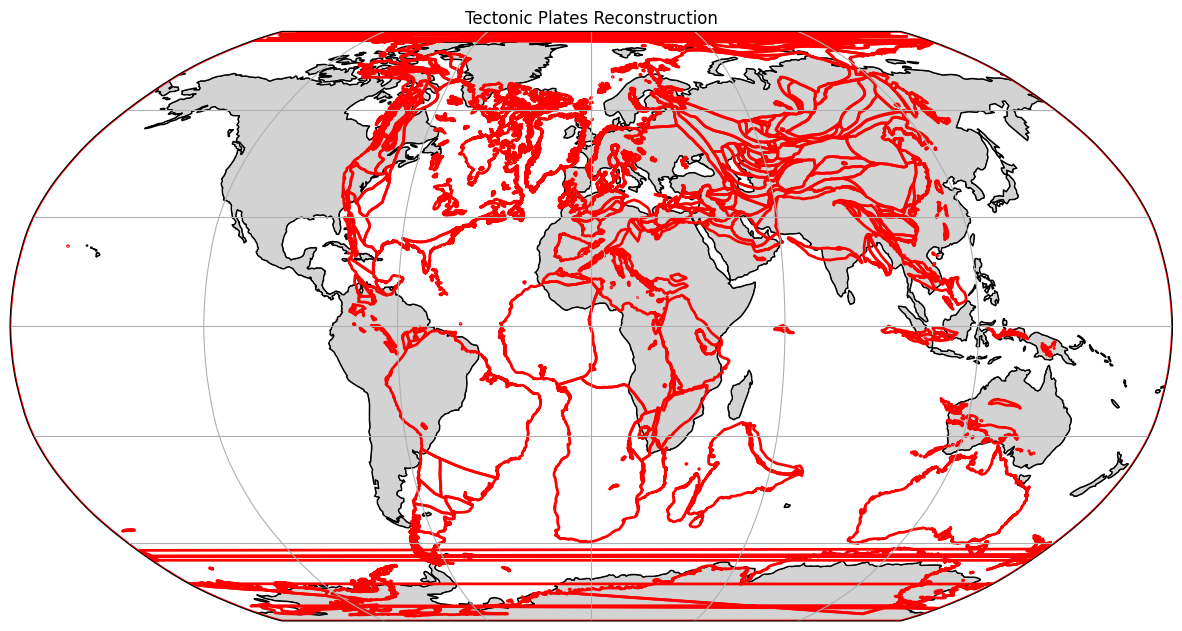

In [138]:
create_plate_map([Polygon(i) for i in rotatedPolygons])

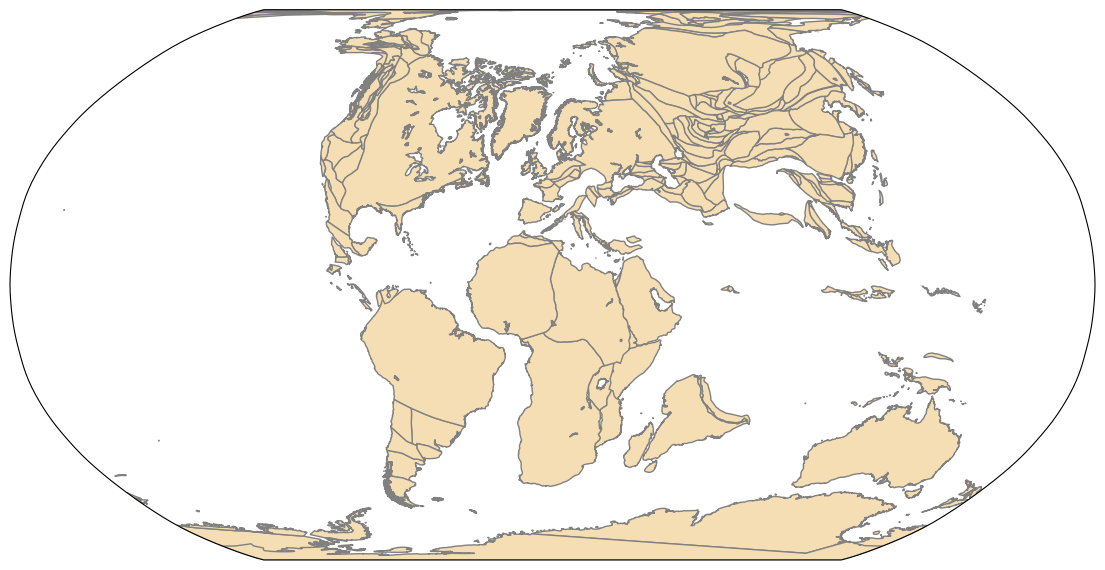

In [136]:
pygplates.reconstruct('coastlines.gpml', 'rotation.rot', '/content/tmp.shp', 100, 0)

fig = plt.figure(figsize=(14,10))
ax_map = fig.add_subplot(111, projection=ccrs.Robinson())

shp_coast = shpreader.Reader('/content/tmp.shp')
ft_coast = cfeature.ShapelyFeature(shp_coast.geometries(), crs=ccrs.PlateCarree())

ax_map.add_feature(ft_coast, facecolor='Wheat', edgecolor='Grey')

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

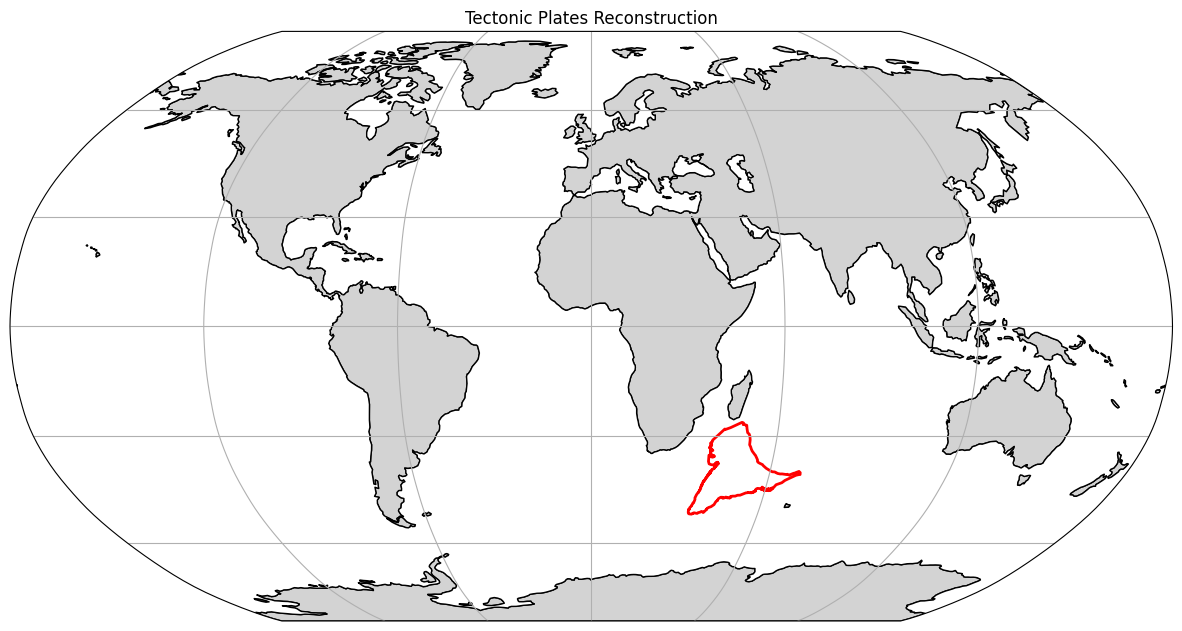

In [137]:
polygonOnSphere = pygplates.PolygonOnSphere(examplePolygon)
rotation_model = pygplates.RotationModel('rotation.rot')
rotation = rotation_model.get_rotation(100, 501)
rotatedPolygon = rotation * polygonOnSphere
coords = rotatedPolygon.to_lat_lon_array()
lon_lat_coords = [(point[1], point[0]) for point in coords]
create_plate_map([Polygon(lon_lat_coords)])

(25.74, -51.510000000000005)
-0.5548401692089975


(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Tectonic Plates Reconstruction'}>)

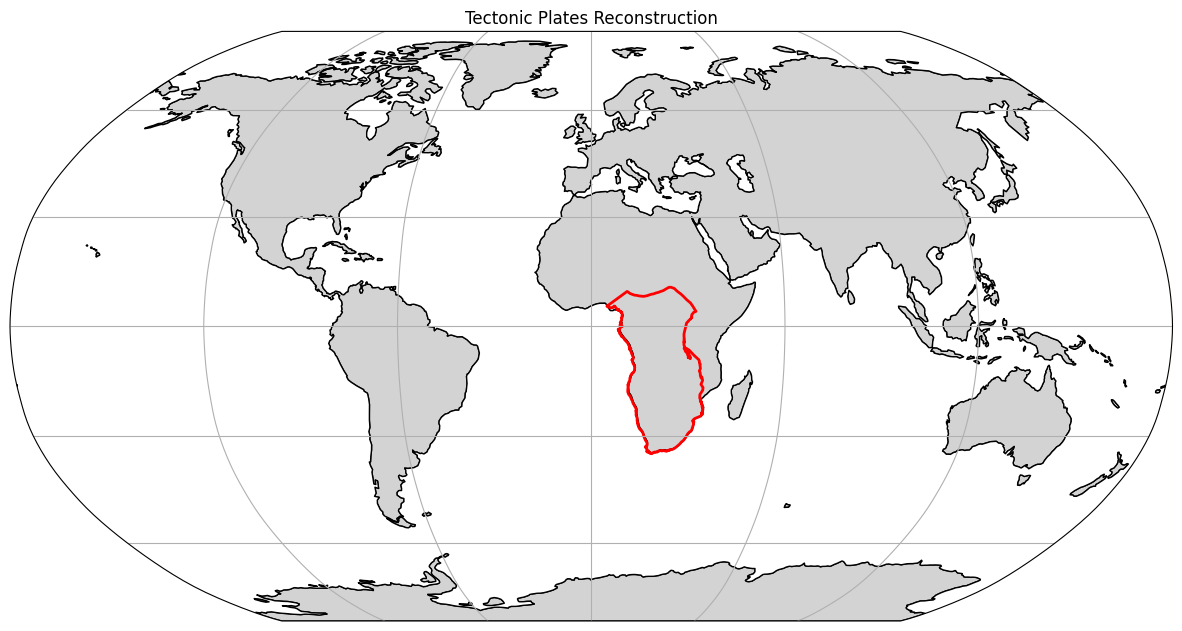

In [133]:
latlon, angle = rotation_model.get_rotation(100, 701).get_euler_pole_and_angle()
latlon = latlon.to_lat_lon()
print(latlon)
print(angle)
# latlon_to_xyz(np.array([latlon]))[0]
rotationMatrix = create_rotation_matrix(latlon_to_xyz(np.array([latlon]))[0],
                np.radians(angle))
rotatedPolygon = np.dot(latlon_to_xyz(examplePolygon), rotationMatrix.T)
rotatedPolygon = xyz_to_latlon(rotatedPolygon)
create_plate_map([Polygon(rotatedPolygon)])

In [ ]:
nx.shortest_path(dg, source=plateId, target=666666)

[701, 0.0, 666666.0]

In [ ]:
rotationDf[(rotationDf['moving_plate_id'] == 103) & (rotationDf['age_ma'] == 400)]

moving_plate_id  age_ma  euler_pole_lat  euler_pole_lon  \
24134              103   400.0           64.18         -129.65   

       rotation_angle  fixed_plate_id  
24134          -34.25             101

not empty
not empty
not empty
not empty
not empty
not empty
not empty
not empty
not empty


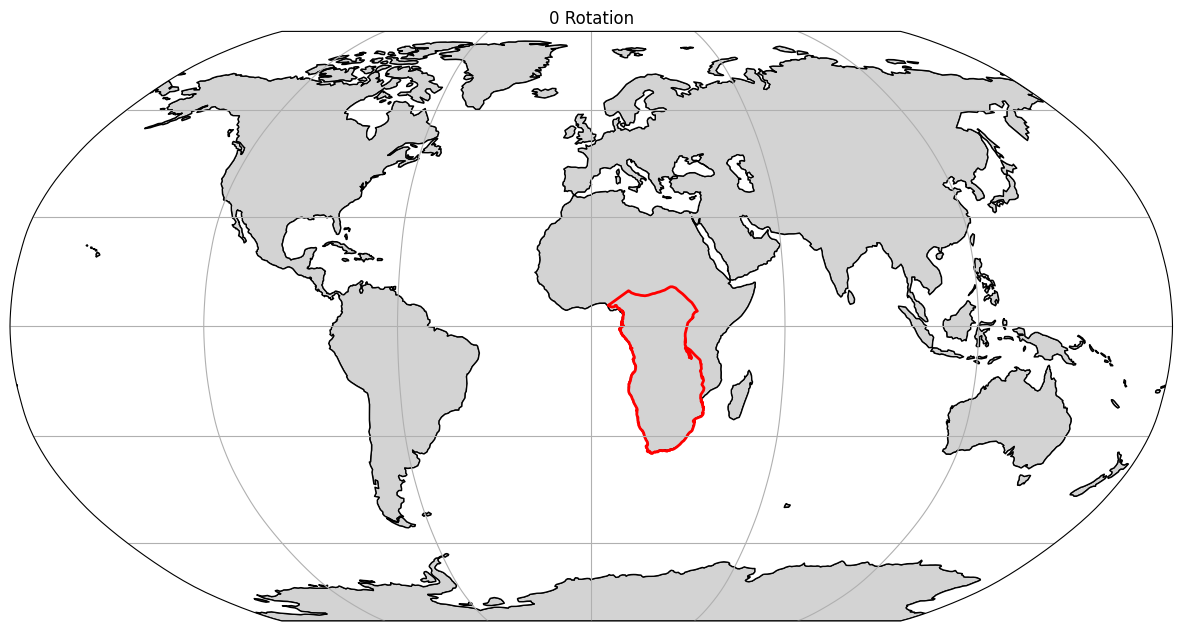

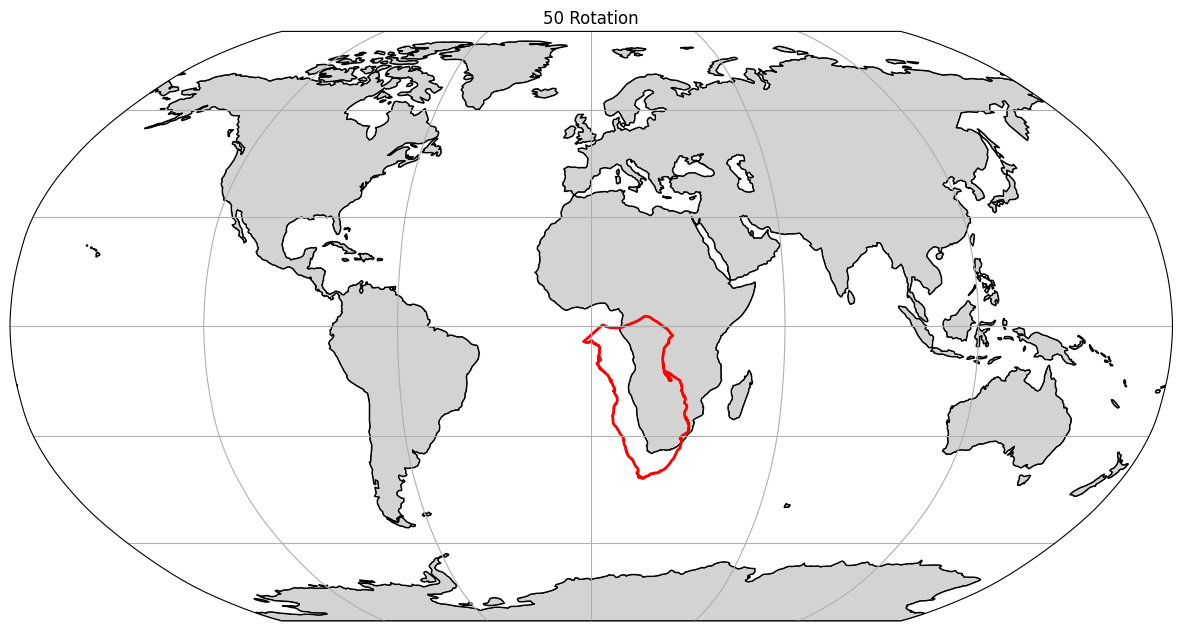

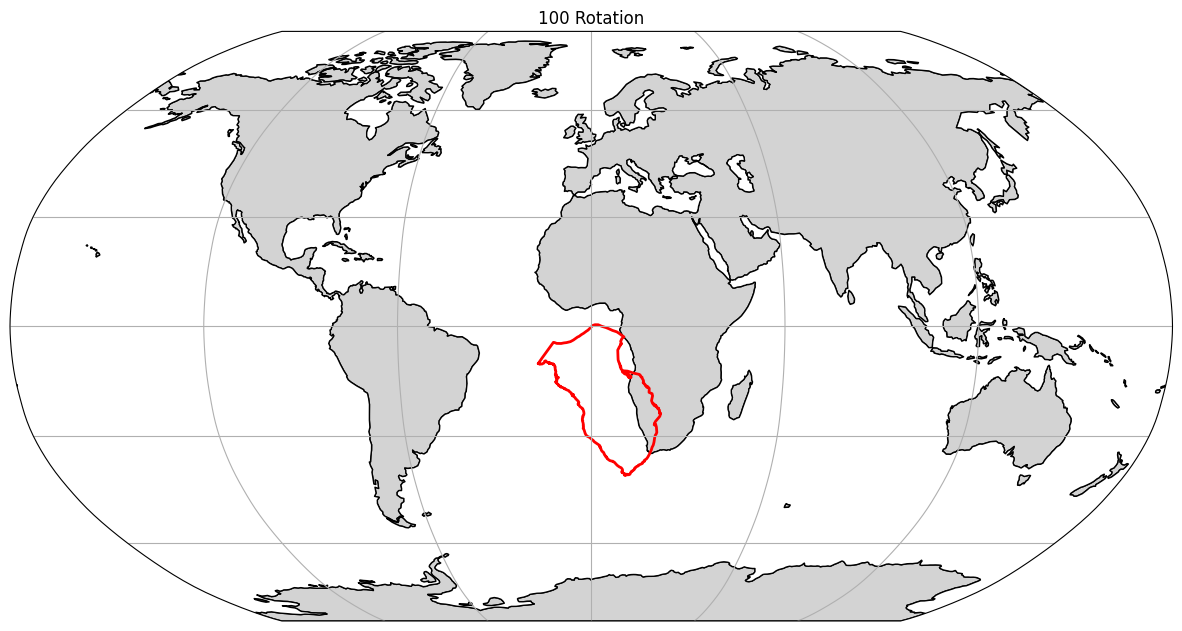

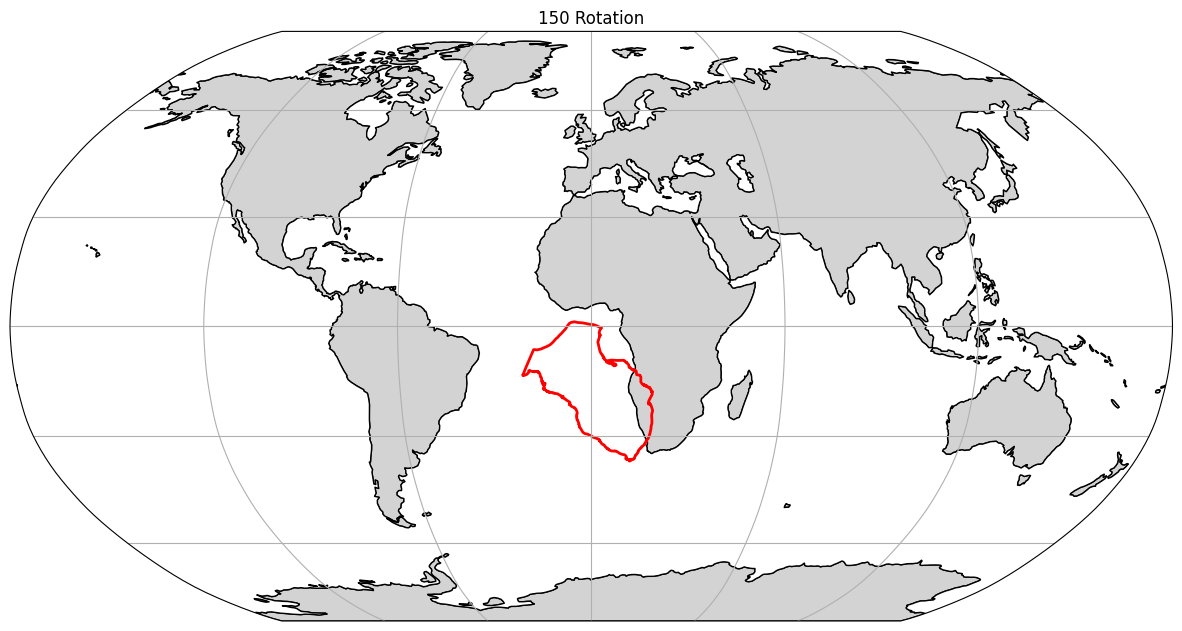

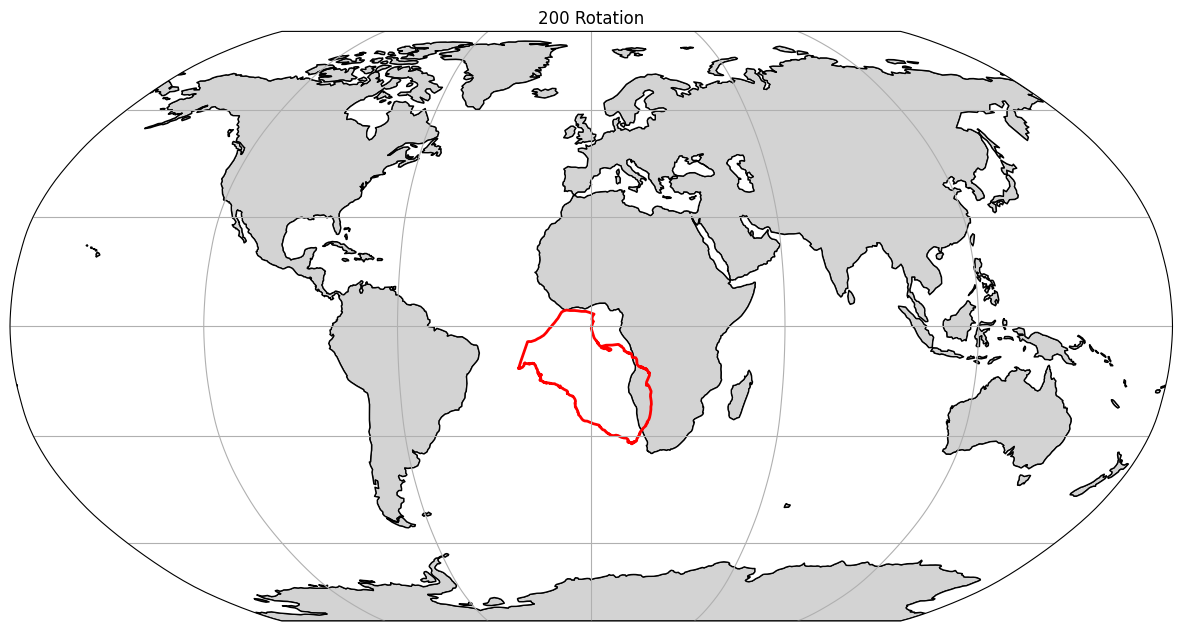

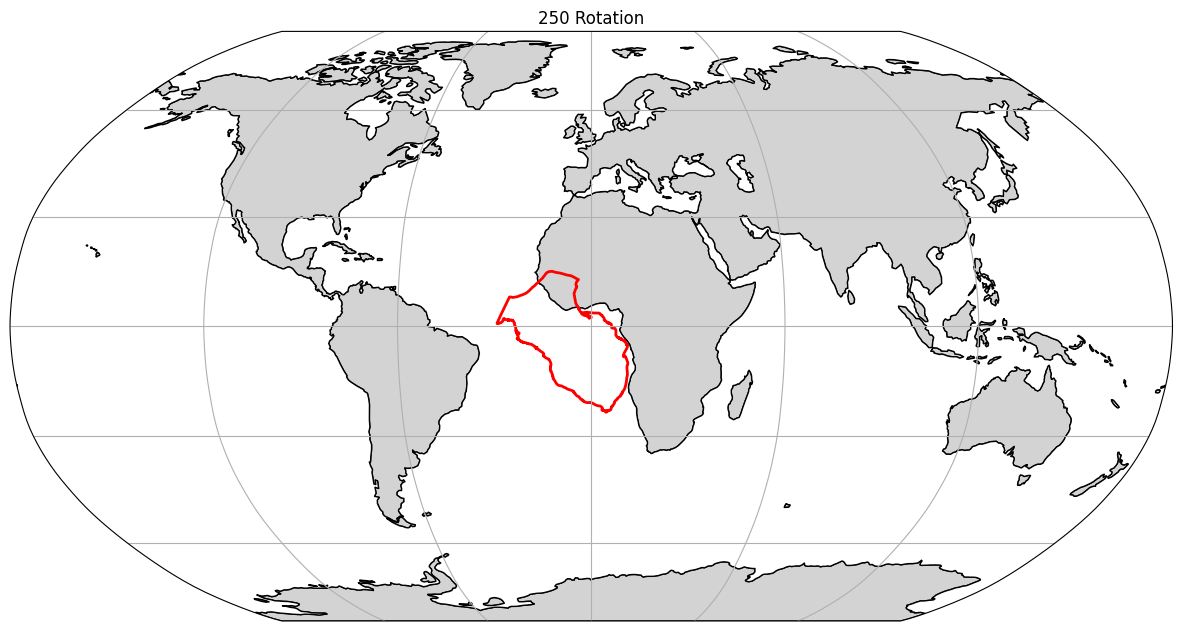

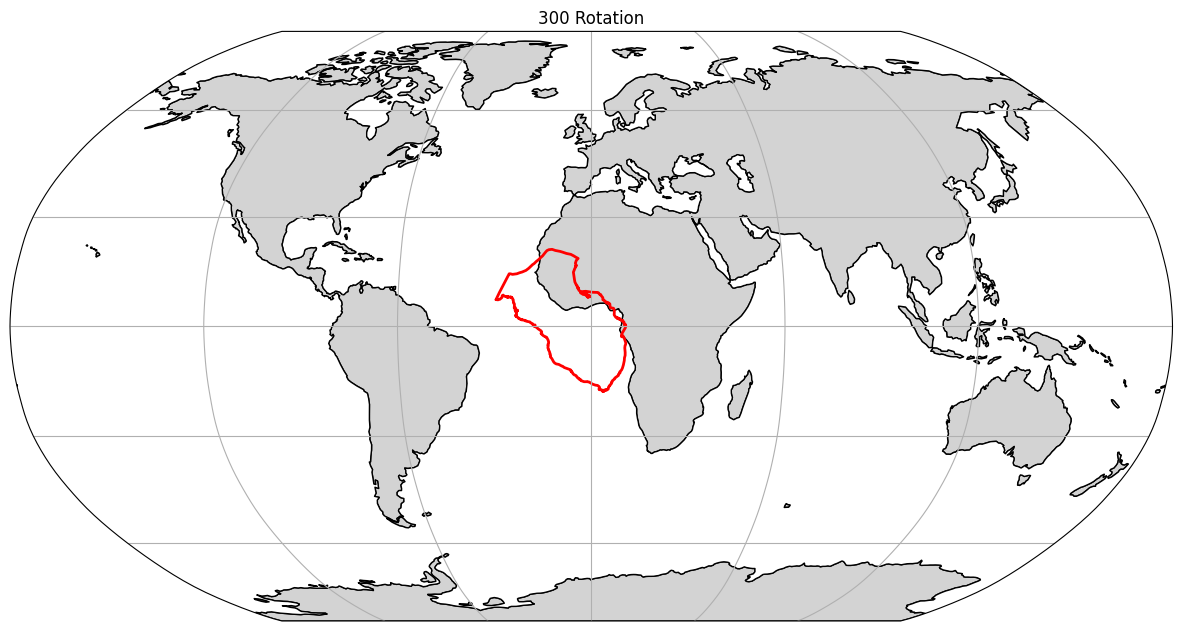

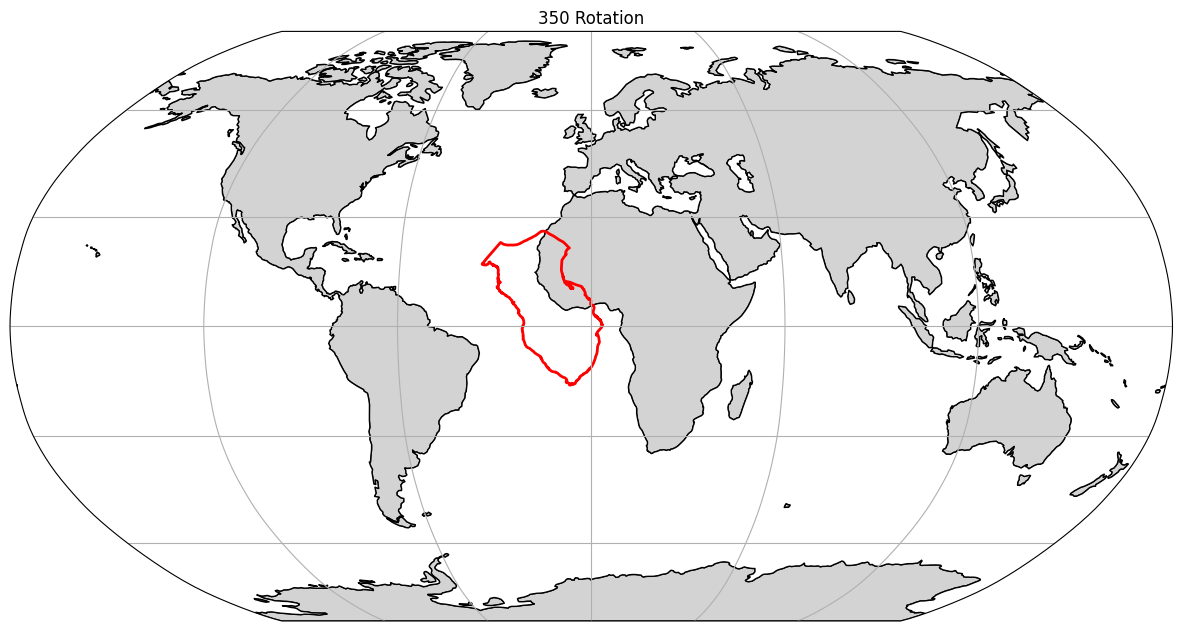

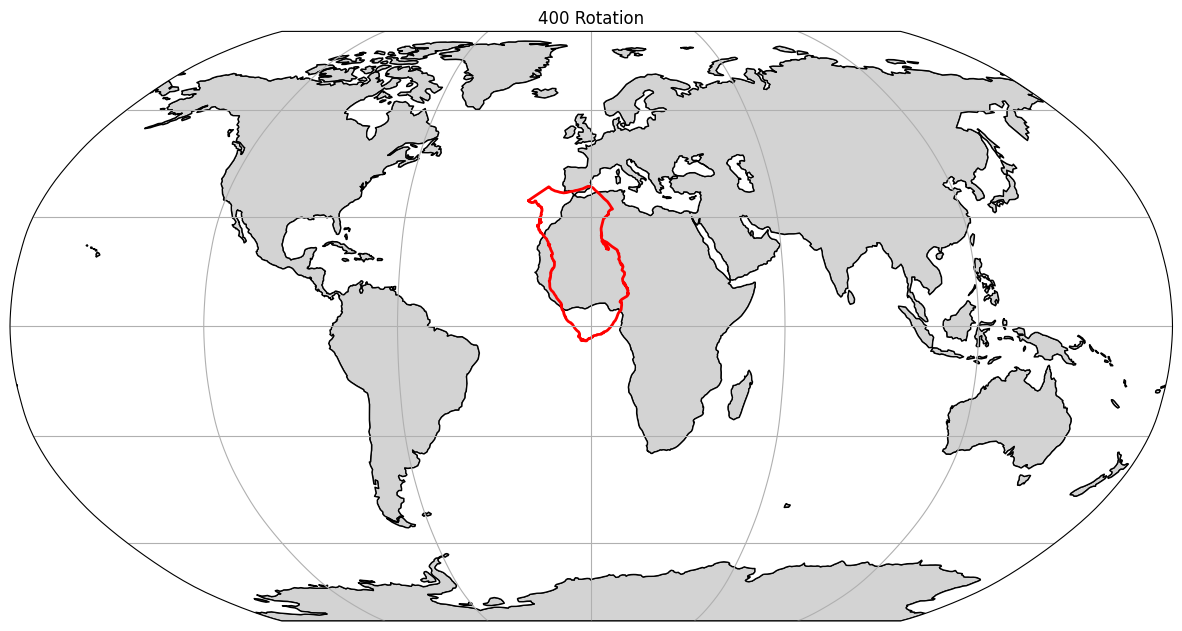

In [ ]:
for i in range(0, 410, 50):
    plotRotatedPolygon(examplePolygon, i)

In [ ]:
# Example usage:
points = np.array([
    [45, -120],  # lat, lon pairs in degrees
    [30, 60],
    [-15, 10]
])
print(f'Points: {points}')
# Convert to 3D coordinates
xyz_points = latlon_to_xyz(points)
print(f'XYZ Points: {xyz_points}')
# Define rotation (e.g., around pole at 45°N, 90°E by 30 degrees)
pole = np.array([45, 90])  # lat, lon of Euler pole
pole_xyz = latlon_to_xyz(pole.reshape(1, 2))[0]  # convert pole to 3D
angle = np.radians(30)  # rotation angle in radians

# Rotate the points
rotated_xyz = rotate_points(xyz_points, pole_xyz, angle)
print(f'Rotated XYZ Points: {rotated_xyz}')

# Convert back to lat/lon
rotated_latlon = xyz_to_latlon(rotated_xyz)
print(f'Rotated Lat/Lon Points: {rotated_latlon}')

pole1 = rotationDf[(rotationDf['moving_plate_id'] == 701) & (rotationDf['age_ma'] == 400)]
pole1LatLon = np.array(pole1[['euler_pole_lat', 'euler_pole_lon']])
rotationAnglePole1 = np.radians(pole1['rotation_angle'].values[0])
pole2 = rotationDf[(rotationDf['moving_plate_id'] == 0) & (rotationDf['age_ma'] == 400)]
pole2LatLon = np.array(pole2[['euler_pole_lat', 'euler_pole_lon']])
rotationAnglePole2 = np.radians(pole2['rotation_angle'].values[0])